# Aircraft Crashes Data Clustering

## Overview

This notebook explores different clustering of aircraft accidents since 1970 and compares the different results. The data has already been cleaned in the [EDA notebook](data_analysis.ipynb).

## Data Preprocessing

In [1]:
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Load data
with open('data/cleaned_data.pkl', 'rb') as handle:
	df = pickle.load(handle)
df.head()

,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
0,1970-01-02,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951.0,Multi Piston Engines,Unknown,Landing (descent or approach),Cargo,Mountains,...,Laos,Asia,19.111016,102.922537,Destroyed,False,4,4,0.0,Unknown
1,1970-01-02,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943.0,Multi Piston Engines,Unknown,Takeoff (climb),Training,Airport (less than 10 km from airport),...,United States of America,North America,34.832246,-92.259758,Destroyed,True,2,0,0.0,Human factor
2,1970-01-03,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954.0,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),...,Vietnam,Asia,11.576983,108.986539,Unknown,True,5,0,0.0,Technical failure
3,1970-01-05,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),...,Spain,Europe,28.655116,-17.857269,Destroyed,True,49,0,0.0,Unknown
4,1970-01-05,Accident,Convair CV-990,Spantax,1962.0,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),Positioning,Airport (less than 10 km from airport),...,Sweden,Europe,59.646792,17.937044,Destroyed,True,10,5,0.0,Human factor


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13622 entries, 0 to 13621
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              13622 non-null  datetime64[ns]
 1   category          13622 non-null  category      
 2   type              13622 non-null  object        
 3   operator          13622 non-null  object        
 4   yom               13622 non-null  float64       
 5   engine            13622 non-null  category      
 6   engine_model      13622 non-null  object        
 7   flight_phase      13622 non-null  object        
 8   flight_type       13622 non-null  object        
 9   site              13622 non-null  object        
 10  location          13622 non-null  object        
 11  country           13622 non-null  object        
 12  region            13622 non-null  object        
 13  latitude          13622 non-null  float64       
 14  longitude         1362

In [4]:
# Split date in three columns
df.insert(0, 'year', df['date'].dt.year)
df.insert(1, 'month', df['date'].dt.month)
df.insert(2, 'day', df['date'].dt.day)
df = df.drop('date', axis=1)
df.head()

,year,month,day,category,type,operator,yom,engine,engine_model,flight_phase,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
0,1970,1,2,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951.0,Multi Piston Engines,Unknown,Landing (descent or approach),...,Laos,Asia,19.111016,102.922537,Destroyed,False,4,4,0.0,Unknown
1,1970,1,2,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943.0,Multi Piston Engines,Unknown,Takeoff (climb),...,United States of America,North America,34.832246,-92.259758,Destroyed,True,2,0,0.0,Human factor
2,1970,1,3,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954.0,Unknown,Unknown,Landing (descent or approach),...,Vietnam,Asia,11.576983,108.986539,Unknown,True,5,0,0.0,Technical failure
3,1970,1,5,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),...,Spain,Europe,28.655116,-17.857269,Destroyed,True,49,0,0.0,Unknown
4,1970,1,5,Accident,Convair CV-990,Spantax,1962.0,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),...,Sweden,Europe,59.646792,17.937044,Destroyed,True,10,5,0.0,Human factor


### Reduce cardinality of string values

In [5]:
# Get string columns with more than 10 unique values
nb_unique = df.select_dtypes(include=['object']).nunique()
string_columns = nb_unique[nb_unique > 10].index
string_columns

Index(['type', 'operator', 'engine_model', 'flight_type', 'location',
       'country'],
      dtype='object')

In [6]:
# Reduce cardinality to 10 by only keeping the most frequent values
for column in string_columns:
  values = list(df[column].value_counts().head(9).index)
  df[column] = np.where(df[column].isin(values), df[column], 'Other')

In [7]:
# Use Ordinal Encoding for category columns
cat_columns = df.select_dtypes(include=['category']).columns
ordinal_encoder = OrdinalEncoder()
encoded_cols = ordinal_encoder.fit_transform(df[cat_columns])
new_df = pd.DataFrame(encoded_cols, columns=ordinal_encoder.get_feature_names_out())
df = df.drop(columns=cat_columns, axis=1).join(new_df)

In [8]:
# Use One Hot Encoding for other columns
string_columns = df.select_dtypes(include=['object', 'bool']).columns
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = onehot_encoder.fit_transform(df[string_columns])
new_df = pd.DataFrame(encoded_cols, columns=onehot_encoder.get_feature_names_out())
df = df.drop(columns=string_columns, axis=1).join(new_df)

In [9]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [10]:
# Export data
df.to_csv('data/preprocessed_data.csv', index=False)

## Feature Engineering

In [11]:
df.shape

(13622, 91)

In [12]:
X = df.copy()

In [13]:
# Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=scaler.get_feature_names_out())
X_scaled.head()

,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities,category,...,region_North America,region_Oceania,region_South America,region_World,survivors_True,cause_Other causes,cause_Technical failure,"cause_Terrorism act, hijacking, sabotage, any kind of hostile action",cause_Unknown,cause_Weather
0,-1.490905,-1.612414,-1.571205,-1.452970,-0.311979,1.464318,-0.297525,-0.110024,-0.043306,-0.952406,...,-0.729696,-0.188205,-0.353612,-0.09816,-0.973483,-0.170544,-0.535645,-0.15683,1.92493,-0.201992
1,-1.490905,-1.612414,-1.571205,-1.991382,0.308073,-0.855292,-0.355994,-0.295956,-0.043306,-0.952406,...,1.370434,-0.188205,-0.353612,-0.09816,1.027239,-0.170544,-0.535645,-0.15683,-0.51950,-0.201992
2,-1.490905,-1.612414,-1.458237,-1.251065,-0.609125,1.536384,-0.268290,-0.295956,-0.043306,1.033158,...,-0.729696,-0.188205,-0.353612,-0.09816,1.027239,-0.170544,1.866909,-0.15683,-0.51950,-0.201992
3,-1.490905,-1.612414,-1.232302,-0.308845,0.064444,0.028932,1.018033,-0.295956,-0.043306,-0.952406,...,-0.729696,-0.188205,-0.353612,-0.09816,1.027239,-0.170544,-0.535645,-0.15683,1.92493,-0.201992
4,-1.490905,-1.612414,-1.232302,-0.712654,1.286771,0.454323,-0.122117,-0.063541,-0.043306,-0.952406,...,-0.729696,-0.188205,-0.353612,-0.09816,1.027239,-0.170544,-0.535645,-0.15683,-0.51950,-0.201992


In [ ]:
# Use PCA to reduce dimensionality to 10
pca = PCA(n_components=10, whiten=True, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [15]:
X_pca = pd.DataFrame(X_pca, columns=pca.get_feature_names_out())
X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,0.727073,0.796261,0.352179,0.084293,-0.315504,-1.024586,-0.512205,-0.408983,0.146683,0.105304
1,-0.651942,-0.616058,-0.579055,1.449882,0.044010,-0.832017,-0.112487,0.229800,-0.278446,-0.120159
2,0.190197,1.677357,-0.196072,0.379985,1.473557,-2.385856,0.444268,-0.848350,1.399163,-0.416984
3,0.697001,0.080474,0.348239,-0.438762,-0.114091,-0.827116,-0.881833,0.218203,-0.877688,-0.008901
4,0.885118,-0.705685,-0.380067,0.095551,0.274960,-0.322492,-1.178009,1.106552,-1.417098,-0.900353


In [16]:
# Export data
X_pca.to_csv('data/pca_preprocessed_data.csv', index=False)

## Data Modeling

### K-Means

#### Find optimal k

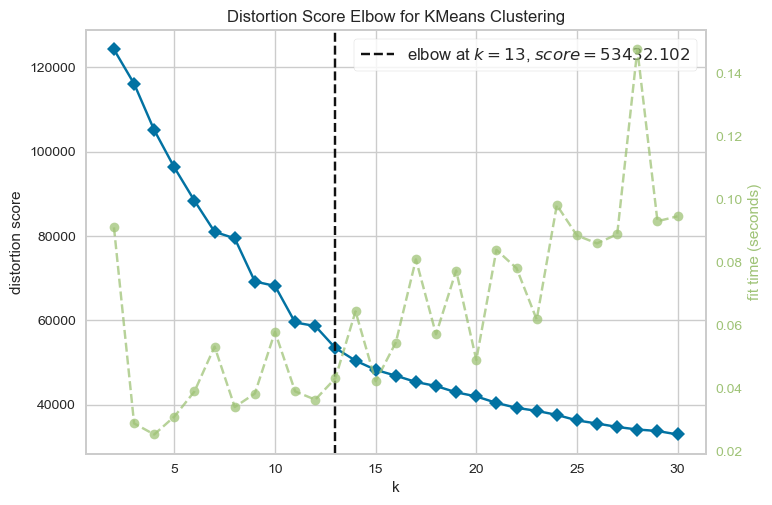

In [17]:
# SSD plot
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=30)
visualizer.fit(X_pca)
visualizer.show();

In [18]:
# Create multiple models for silhouette score
k_values = []
scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X_pca)
    k_values.append(k)
    scores.append(silhouette_score(X_pca, kmeans.labels_, metric='euclidean'))

models = pd.Series(data=scores, index=k_values)

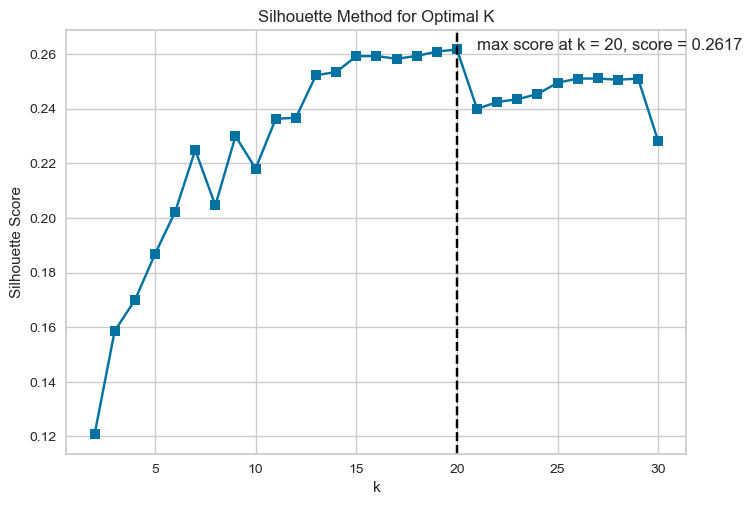

In [19]:
# Silhouette score plot
optimal_k = models.idxmax()
max_score = models.max()

plt.plot(models, marker='s')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.axvline(x=optimal_k, color='black', linestyle='--')
plt.annotate('max score at k = {}, score = {}'.format(optimal_k, round(max_score, 4)), xy=(optimal_k + 1, max_score))
plt.show()

In [20]:
# Based on the silhouette plot, k = 20 seems reasonable
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=20, random_state=42)

In [21]:
original_df = pd.read_csv('data/cleaned_data.csv', parse_dates=['date'])
original_df.insert(0, 'cluster', kmeans.labels_)

#### Visualize the clusters

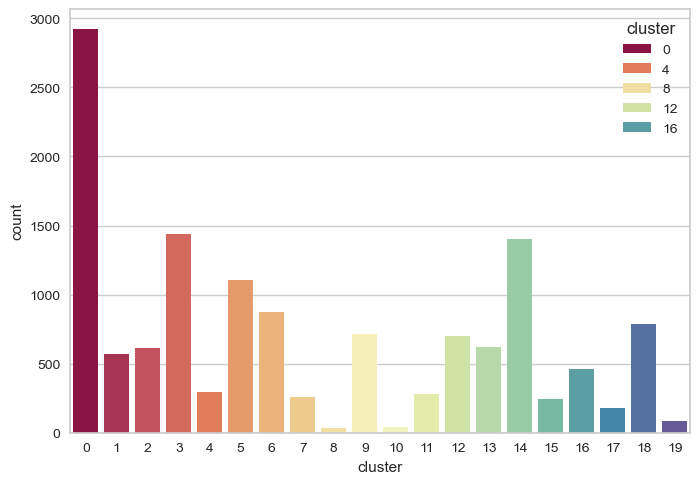

In [22]:
# Plot distribution of the clusters
sns.countplot(data=original_df, x='cluster', hue='cluster', palette='Spectral');

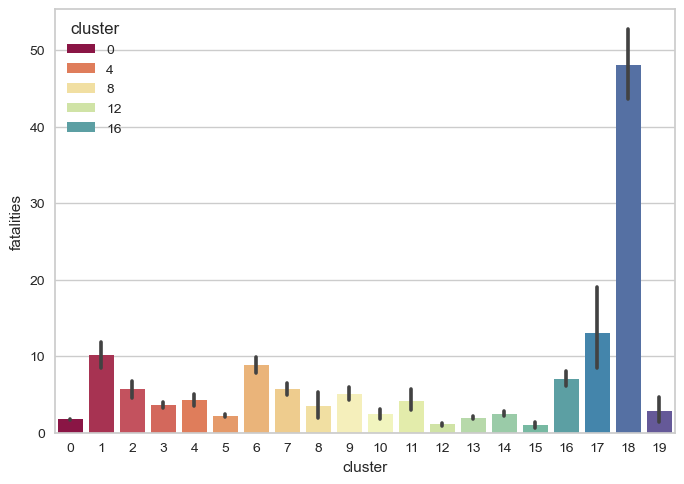

In [23]:
# Plot the average number of fatalites by cluster
sns.barplot(data=original_df, x='cluster', y='fatalities', hue='cluster', palette='Spectral');

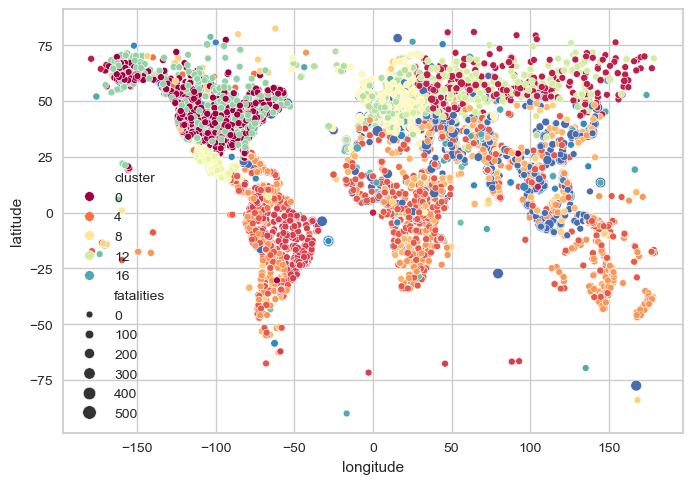

In [24]:
# Plot coordinates colored by clusters and sized by fatalities
sns.scatterplot(data=original_df, x='longitude', y='latitude', hue='cluster', size='fatalities', palette='Spectral');

#### Analyse each cluster

In [25]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [26]:
cluster0 = original_df[original_df['cluster'] == 0]
cluster0.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
1621,0,1974-10-20,Unknown,Cessna 414 Chancellor,Holloway Construction,1973.0,Unknown,Unknown,Takeoff (climb),Executive/Corporate/Business,Airport (less than 10 km from airport),"Jackson-Reynolds Field, Michigan",United States of America,North America,32.299869,-90.183041,Unknown,True,1,0,0.0,Human factor
12228,0,2014-06-25,Unknown,Beechcraft 90 King Air,BECS LLC,1997.0,Unknown,Unknown,Landing (descent or approach),Executive/Corporate/Business,Airport (less than 10 km from airport),"Houston-Municipal, Mississippi",United States of America,North America,33.887171,-89.022435,Unknown,True,5,0,0.0,Human factor
7952,0,1994-11-01,Unknown,Cessna 421A Golden Eagle I,Keys Family LLC,1968.0,Unknown,Unknown,Landing (descent or approach),Executive/Corporate/Business,Airport (less than 10 km from airport),"Reno-Tahoe (ex Cannon), Nevada",United States of America,North America,26.492533,92.330879,Unknown,True,4,0,0.0,Human factor
8093,0,1995-04-12,Unknown,Piper PA-60 Aerostar (Ted Smith 600),Robert L. Kovach,1981.0,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"Danbury, Connecticut",United States of America,North America,41.394817,-73.454011,Unknown,True,4,1,0.0,Human factor
1921,0,1975-08-19,Unknown,Cessna 401,Schepps Grocery,1968.0,Unknown,Unknown,Landing (descent or approach),Executive/Corporate/Business,Airport (less than 10 km from airport),"Austin-Robert Mueller, Texas",United States of America,North America,30.271129,-97.743700,Unknown,False,3,3,0.0,Human factor


In [27]:
cluster0.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,2920.0,2920,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,0.0,1991-06-29 11:57:32.054794496,1970.523288,39.903821,-96.525226,2.967808,1.773630,0.009932
min,0.0,1970-01-16 00:00:00,1927.000000,-34.101363,-170.483478,0.000000,0.000000,0.000000
25%,0.0,1979-08-06 12:00:00,1962.000000,33.519430,-114.807354,1.000000,0.000000,0.000000
50%,0.0,1988-01-30 12:00:00,1972.500000,39.100220,-93.578618,2.000000,1.000000,0.000000
75%,0.0,2001-10-10 00:00:00,1978.000000,44.254314,-81.657513,4.000000,2.000000,0.000000
max,0.0,2024-12-11 00:00:00,2022.000000,77.433172,151.186830,107.000000,14.000000,4.000000
std,0.0,NaN,13.260202,10.078386,34.175219,3.091334,2.044668,0.141823


In [28]:
cluster0.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,2920,2920,2920,2920,2920,2920,2920,2920,2920,2920,2920,2920,2920,2920
unique,2,132,2438,4,1,5,27,7,2043,2,1,3,2,6
top,Unknown,De Havilland DHC-2 Beaver,Private American,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"Ketchikan, Alaska",United States of America,North America,Unknown,False,Human factor
freq,2901,177,91,2910,2920,1224,958,1617,12,2617,2920,2899,1708,1907


In [29]:
cluster1 = original_df[original_df['cluster'] == 1]
cluster1.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
13262,1,2021-11-03,Accident,Antonov AN-12,Grodno Aircompany (Aviakompania Grodno),1968.0,Multi Turboprop Engines,Ivchenko AI-20M,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"Irkutsk-Intl, Irkutsk oblast",Russia,Asia,52.266805,104.375540,Destroyed,False,9,9,0.0,Unknown
1463,1,1974-04-16,Accident,Antonov AN-2,Aeroflot - Russian International Airlines,1960.0,1 Piston engine,Unknown,Flight,Scheduled Revenue Flight,Mountains,"Kutaisi, Imereti",Georgia,Asia,42.259679,42.663374,Destroyed,False,0,0,0.0,Weather
6854,1,1990-11-02,Accident,Antonov AN-26,Aeroflot - Russian International Airlines,1979.0,Multi Turboprop Engines,Ivchenko AI-24VT,Landing (descent or approach),Fire fighting,Airport (less than 10 km from airport),"Nyurba, Republic of Yakutia (Sakha)",Russia,Asia,63.286648,118.354149,Destroyed,False,0,0,0.0,Unknown
6512,1,1989-09-15,Accident,Yakovlev Yak-40,Aeroflot - Russian International Airlines,1974.0,Multi Jet Engines,Ivchenko AI-25,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Jalal-Abad, Jalal-Abad Province",Kyrgyzstan,Asia,40.929818,73.001190,Destroyed,True,30,0,0.0,Human factor
2212,1,1976-08-27,Accident,Antonov AN-2,Aeroflot - Russian International Airlines,1961.0,1 Piston engine,Unknown,Flight,Scheduled Revenue Flight,"Plain, Valley","Berezovo, Tyumen oblast",Russia,Asia,63.937625,65.045545,Destroyed,False,0,0,0.0,Human factor


In [30]:
cluster1.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,571.0,571,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000
mean,1.0,1988-10-16 15:43:11.243432576,1972.322242,53.799609,75.180629,22.775832,10.134851,0.176883
min,1.0,1970-01-28 00:00:00,1945.000000,-1.894429,-179.491343,0.000000,0.000000,0.000000
25%,1.0,1976-02-22 00:00:00,1962.000000,49.191062,40.633975,4.000000,0.000000,0.000000
50%,1.0,1986-10-20 00:00:00,1972.000000,55.342119,65.434929,10.000000,1.000000,0.000000
75%,1.0,1996-11-17 00:00:00,1979.000000,59.732690,106.177735,29.000000,10.000000,0.000000
max,1.0,2024-10-13 00:00:00,2017.000000,80.916649,177.506092,228.000000,122.000000,45.000000
std,0.0,NaN,12.629172,10.755523,48.573525,32.471723,20.457256,2.258370


In [31]:
cluster1.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,571,571,571,571,571,571,571,571,571,571,571,571,571,571
unique,4,68,149,6,54,5,25,6,389,16,2,5,2,6
top,Accident,Antonov AN-2,Aeroflot - Russian International Airlines,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Moscow-Vnukovo, Moscow oblast",Russia,Asia,Destroyed,True,Human factor
freq,439,93,324,207,268,251,307,370,11,489,563,401,306,290


In [32]:
cluster2 = original_df[original_df['cluster'] == 2]
cluster2.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
4307,2,1982-05-24,Accident,Boeing 737-200,VASP - Viação Aérea de São Paulo,1974.0,Multi Jet Engines,Pratt & Whitney JT8D-7,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Brasília, Distrito Federal",Brazil,South America,-15.793987,-47.882800,Destroyed,True,118,2,0.0,Human factor
916,2,1972-10-18,Accident,NAMC YS-11,Cruzeiro do Sul,1968.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"São Paulo-Congonhas, São Paulo",Brazil,South America,-23.627415,-46.655561,Destroyed,False,0,0,0.0,Human factor
11481,2,2010-05-05,Unknown,Embraer ERJ-145,SATENA - Servicio de Aeronavegacion a Territorios Nacionales,2005.0,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Mitú-Fabio Alberto León Bentley, Vaupés",Colombia,South America,1.253850,-70.234558,Unknown,True,42,0,0.0,Human factor
2054,2,1976-02-04,Accident,Douglas DC-6,LAC Colombia - Lineas Aéreas del Caribe,1952.0,Multi Piston Engines,Unknown,Takeoff (climb),Cargo,"Lake, Sea, Ocean, River","Santa Marta-Simón Bolívar, Magdalena",Colombia,South America,11.118892,-74.231189,Destroyed,False,4,4,0.0,Technical failure
13005,2,2019-09-15,Unknown,Piper PA-31-350 Navajo Chieftain,TransPacificos,1974.0,Unknown,Unknown,Takeoff (climb),Scheduled Revenue Flight,City,"Popayán-Guillermo León Valencia, Cauca",Colombia,South America,2.452826,-76.607634,Unknown,True,9,7,0.0,Other causes


In [33]:
cluster2.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,612.0,612,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000
mean,2.0,1994-06-24 18:18:49.411764736,1973.973856,-7.747252,-55.981164,12.934641,5.656863,0.119281
min,2.0,1970-02-05 00:00:00,1937.000000,-71.672740,-81.708616,0.000000,0.000000,0.000000
25%,2.0,1980-04-08 18:00:00,1965.000000,-22.209363,-73.850488,3.000000,0.000000,0.000000
50%,2.0,1993-08-28 12:00:00,1974.000000,-4.894725,-56.045074,5.000000,2.000000,0.000000
75%,2.0,2007-03-09 12:00:00,1983.000000,4.653382,-46.655561,10.000000,5.000000,0.000000
max,2.0,2025-02-07 00:00:00,2019.000000,37.703228,93.011418,282.000000,154.000000,22.000000
std,0.0,NaN,17.173495,15.152401,25.568810,24.630407,14.039105,1.309847


In [34]:
cluster2.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,612,612,612,612,612,612,612,612,612,612,612,612,612,612
unique,4,170,332,6,93,6,25,6,379,7,3,6,2,6
top,Accident,Embraer EMB-110 Bandeirante,Brazilian Air Force - Força Aérea Brasileira (1941-),Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"São Paulo-Congonhas, São Paulo",Brazil,South America,Destroyed,True,Human factor
freq,392,40,53,236,372,304,151,331,15,358,606,350,311,260


In [35]:
cluster3 = original_df[original_df['cluster'] == 3]
cluster3.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
5662,3,1987-02-02,Accident,Curtiss C-46 Commando,Transportes Aéreos San Miguel - TASMI,1945.0,Multi Piston Engines,Unknown,Flight,Cargo,"Plain, Valley","San Ignacio de Moxos, Beni",Bolivia,South America,-14.996158,-65.641067,Destroyed,True,5,0,0.0,Technical failure
5734,3,1987-05-08,Accident,Casa 212 Aviocar,American Eagle,1982.0,Multi Turboprop Engines,Garrett TPE331-10R-511C,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Mayaguez-Eugenio Maria de Hostos, All Puerto Rico",Puerto Rico,Central America,18.255257,-67.148604,Destroyed,True,6,2,0.0,Human factor
8904,3,1998-05-07,Accident,Antonov AN-32,Gama Air,1990.0,Multi Turboprop Engines,Ivchenko AI-20,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"Vaalwater, Limpopo",South Africa,Africa,-24.298056,28.120833,Destroyed,True,4,0,0.0,Technical failure
1929,3,1975-08-30,Accident,Curtiss C-46 Commando,Transportes Aéreos Benianos - TABSA,1945.0,Multi Piston Engines,Unknown,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"Trinidad-Jorge Heinrich Arauz, Beni",Bolivia,South America,26.492533,92.330879,Destroyed,True,3,0,0.0,Technical failure
8036,3,1995-01-31,Accident,Boeing 727-100,Angola Air Charter,1966.0,Multi Jet Engines,Pratt & Whitney JT8D-7B,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"Huambo-Albano Machado, Huambo",Angola,Africa,-12.807499,15.757342,Destroyed,True,3,0,0.0,Human factor


In [36]:
cluster3.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1439.0,1439,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000
mean,3.0,1999-06-28 10:53:27.227241216,1976.992356,2.967861,3.358947,13.338429,3.624044,0.118138
min,3.0,1970-01-14 00:00:00,1900.000000,-67.567784,-178.958020,0.000000,0.000000,0.000000
25%,3.0,1988-12-16 00:00:00,1967.000000,-8.697060,-66.804309,3.000000,0.000000,0.000000
50%,3.0,2000-08-26 00:00:00,1978.000000,5.360779,15.253856,6.000000,0.000000,0.000000
75%,3.0,2010-08-28 00:00:00,1988.000000,16.099801,36.824447,12.000000,4.000000,0.000000
max,3.0,2025-03-17 00:00:00,2023.000000,65.360401,179.314337,171.000000,75.000000,30.000000
std,0.0,NaN,16.241889,19.516169,70.886132,21.823419,7.868159,1.395382


In [37]:
cluster3.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439
unique,4,211,1013,6,292,6,27,6,950,139,7,7,2,6
top,Accident,Britten-Norman Islander,Argentinian Air Force - Fuerza Aérea Argentina,Multi Turboprop Engines,Unknown,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"Bukavu, Sud-Kivu",Democratic Republic of Congo,Africa,Destroyed,True,Human factor
freq,1427,121,11,535,435,783,414,922,10,92,589,1221,911,549


In [38]:
cluster4 = original_df[original_df['cluster'] == 4]
cluster4.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
397,4,1971-03-26,Accident,Douglas C-47 Skytrain (DC-3),Jamair,1944.0,Multi Piston Engines,Pratt & Whitney R-1830-92,Flight,Scheduled Revenue Flight,Mountains,"Hasimara, West Bengal",India,Asia,26.726951,89.347300,Destroyed,False,15,15,0.0,Human factor
367,4,1971-02-14,Accident,Douglas C-47 Skytrain (DC-3),Continental Air Services,1944.0,Multi Piston Engines,Unknown,Takeoff (climb),Positioning,Airport (less than 10 km from airport),"Phnom Penh-Pochentong, Phnom Penh",Cambodia,Asia,11.547057,104.848112,Destroyed,False,2,2,0.0,Technical failure
3024,4,1978-10-15,Accident,Douglas C-47 Skytrain (DC-3),Ethiopian Airlines,1944.0,Multi Piston Engines,Pratt & Whitney R-1830-90C,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Soddo, Southern Nations, Nationalities, and Peoples' Region",Ethiopia,Africa,26.492533,92.330879,Destroyed,True,32,0,0.0,Technical failure
469,4,1971-06-27,Unknown,Douglas C-47 Skytrain (DC-3),Lake Riverside Estates,1942.0,Unknown,Unknown,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),"Lake, Sea, Ocean, River","Shelter Cove, California",United States of America,North America,40.030421,-124.073087,Unknown,True,24,17,0.0,Human factor
425,4,1971-05-04,Accident,Douglas C-47 Skytrain (DC-3),TAM Bolivia - Transporte Aéreo Militar Boliviano,1952.0,Multi Piston Engines,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"La Paz-El Alto, La Paz",Bolivia,South America,-16.474936,-68.163635,Destroyed,True,3,0,0.0,Unknown


In [39]:
cluster4.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,297.0,297,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,4.0,1980-12-27 09:22:25.454545472,1944.380471,17.560109,-26.181026,8.592593,4.316498,0.037037
min,4.0,1970-01-13 00:00:00,1941.000000,-45.571180,-171.996880,0.000000,0.000000,0.000000
25%,4.0,1973-06-23 00:00:00,1943.000000,3.586433,-82.399659,2.000000,0.000000,0.000000
50%,4.0,1978-02-10 00:00:00,1944.000000,14.767372,-68.163635,4.000000,0.000000,0.000000
75%,4.0,1984-11-11 00:00:00,1944.000000,35.146025,37.588878,11.000000,5.000000,0.000000
max,4.0,2021-07-08 00:00:00,1965.000000,70.326677,174.986137,44.000000,44.000000,6.000000
std,0.0,NaN,3.274599,24.941946,81.775426,10.359045,8.168051,0.421518


In [40]:
cluster4.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,297,297,297,297,297,297,297,297,297,297,297,297,297,297
unique,3,4,214,2,10,5,23,7,277,64,7,5,2,6
top,Accident,Douglas C-47 Skytrain (DC-3),Ethiopian Airlines,Multi Piston Engines,Pratt & Whitney R-1830-92,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"La Paz-El Alto, La Paz",Colombia,South America,Destroyed,True,Technical failure
freq,263,274,17,274,159,106,81,165,3,39,76,243,149,109


In [41]:
cluster5 = original_df[original_df['cluster'] == 5]
cluster5.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
8972,5,1998-08-22,Unknown,Pilatus PC-6 (Porter & Turbo Porter),Transportes Aéreos Nacionales de la Selva - TANS,1974.0,Unknown,Unknown,Takeoff (climb),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Iquitos-Moronacocha, Loreto",Peru,South America,26.492533,92.330879,Unknown,True,4,0,0.0,Unknown
12141,5,2013-12-19,Unknown,Beechcraft 90 King Air,ATA Aerolineas - Aero Transportes Araucanía,1969.0,Unknown,Unknown,Landing (descent or approach),Positioning,Airport (less than 10 km from airport),"Viña del Mar, Región de Valparaíso",Chile,South America,-33.024453,-71.551764,Unknown,True,2,0,0.0,Technical failure
7066,5,1991-09-03,Unknown,Short SC.7 Skyvan Variant,Airtech Rajawali Udara,1981.0,Unknown,Unknown,Flight,Scheduled Revenue Flight,"Plain, Valley","Long Seridan, Sarawak",Malaysia,Asia,3.977604,115.068984,Unknown,True,20,14,0.0,Technical failure
10035,5,2003-03-12,Unknown,Piper PA-31-350 Navajo Chieftain,Federal Aviation,1978.0,Unknown,Unknown,Flight,Ferry,"Plain, Valley","Las Primaveras, Mendoza",Argentina,South America,-32.922025,-68.671101,Unknown,True,2,0,0.0,Technical failure
6094,5,1988-06-13,Unknown,De Havilland DH.104 Dove,Néstor Benito Ibañez,1948.0,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"La Plata, Buenos Aires province",Argentina,South America,-34.920680,-57.953764,Unknown,True,9,8,0.0,Technical failure


In [42]:
cluster5.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1103.0,1103,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,5.0,1995-08-23 21:27:15.176790656,1974.116954,-5.042413,30.081638,4.230281,2.235721,0.059837
min,5.0,1970-01-10 00:00:00,1934.000000,-62.191101,-171.741216,0.000000,0.000000,0.000000
25%,5.0,1983-04-29 00:00:00,1968.000000,-27.852861,-68.673934,1.000000,0.000000,0.000000
50%,5.0,1994-12-19 00:00:00,1974.000000,-3.380109,28.851389,3.000000,1.000000,0.000000
75%,5.0,2006-11-18 00:00:00,1979.000000,15.626007,139.369942,6.000000,3.000000,0.000000
max,5.0,2025-02-25 00:00:00,2021.000000,71.707003,178.352392,65.000000,34.000000,29.000000
std,0.0,NaN,12.652335,24.143797,96.810305,4.774356,3.263491,0.934347


In [43]:
cluster5.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103
unique,3,148,857,4,1,4,28,6,899,114,7,4,2,6
top,Unknown,Cessna 402,Private Australian,Unknown,Unknown,Flight,Charter/Taxi (Non Scheduled Revenue Flight),Airport (less than 10 km from airport),"Nassau, New Providence",Australia,Oceania,Unknown,False,Unknown
freq,1047,111,31,1053,1103,423,230,480,11,166,312,1043,605,399


In [44]:
cluster6 = original_df[original_df['cluster'] == 6]
cluster6.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
3623,6,1980-05-13,Unknown,Ilyushin II-14,Cubana de Aviación,1957.0,Unknown,Unknown,Flight,Training,"Lake, Sea, Ocean, River","Varadero, Matanzas",Cuba,Central America,23.149578,-81.260025,Unknown,False,3,3,0.0,Unknown
3750,6,1980-09-15,Unknown,Lockheed C-130 Hercules,Royal Saudi Air Force (القوات الجوية الملكية السعودية),1966.0,Unknown,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"Madinah, Al-Madīnah al-Munawarah (المدينة المنورة)",Saudi Arabia,Asia,26.492533,92.330879,Unknown,False,89,89,0.0,Technical failure
9193,6,1999-08-07,Unknown,Short SC.7 Skyvan Variant,Nepalese Army,1970.0,Unknown,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"Surkhet, Bheri",Nepal,Asia,28.517856,81.663771,Unknown,True,2,0,0.0,Other causes
9541,6,2001-01-08,Accident,Casa 212 Aviocar,Indonesian Navy - TNI-AL Tentara Nasional Indonesia - Angkatan Laut,1984.0,Multi Turboprop Engines,Unknown,Flight,Military,Mountains,"Timika, Special Region of Papua",Indonesia,Asia,-4.546913,136.882990,Destroyed,False,9,9,0.0,Human factor
351,6,1971-01-23,Unlawful Interference,Fokker F27 Friendship,Korean Air,1969.0,Multi Turboprop Engines,Unknown,Flight,Scheduled Revenue Flight,"Plain, Valley","Sokcho, Gangwon (강원도)",South Korea,Asia,38.206957,128.591342,Destroyed,True,60,2,0.0,"Terrorism act, hijacking, sabotage, any kind of hostile action"


In [45]:
cluster6.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,875.0,875,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000
mean,6.0,1987-08-24 19:15:17.485714304,1970.260571,13.067942,51.749006,12.256000,8.827429,0.128000
min,6.0,1970-01-02 00:00:00,1939.000000,-66.552683,-141.414092,0.000000,0.000000,0.000000
25%,6.0,1976-05-30 12:00:00,1962.000000,-1.103292,19.912268,2.000000,0.000000,0.000000
50%,6.0,1985-10-12 00:00:00,1970.000000,14.800669,63.133726,5.000000,4.000000,0.000000
75%,6.0,1995-11-14 12:00:00,1978.000000,29.523377,102.922537,14.000000,9.000000,0.000000
max,6.0,2025-03-07 00:00:00,2013.000000,59.560477,178.422303,159.000000,159.000000,14.000000
std,0.0,NaN,13.228004,20.695600,64.148029,18.019017,15.343770,0.996369


In [46]:
cluster6.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,875,875,875,875,875,875,875,875,875,875,875,875,875,875
unique,3,170,385,6,31,6,25,7,715,119,7,5,2,6
top,Unknown,Lockheed C-130 Hercules,Indian Air Force - Bharatiya Vayu Sena,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Phnom Penh-Pochentong, Phnom Penh",India,Asia,Destroyed,False,Unknown
freq,455,51,26,451,773,393,338,429,6,52,501,427,619,391


In [47]:
cluster7 = original_df[original_df['cluster'] == 7]
cluster7.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
6704,7,1990-04-12,Accident,De Havilland DHC-6 Twin Otter,Wideroe - Wideroe's Flyveselskap,1977.0,Multi Turboprop Engines,Pratt & Whitney Canada PT6A-27,Takeoff (climb),Scheduled Revenue Flight,"Lake, Sea, Ocean, River","Værøy (Lofoten Islands), Nordland",Norway,Europe,67.675494,12.666049,Destroyed,False,5,5,0.0,Weather
8020,7,1995-01-17,Accident,De Havilland DHC-6 Twin Otter,Royal Nepal Airlines,1973.0,Multi Turboprop Engines,Pratt & Whitney Canada PT6A-27,Takeoff (climb),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Kathmandu-Tribhuvan, Bagmati",Nepal,Asia,27.693912,85.358220,Destroyed,True,24,2,0.0,Human factor
115,7,1970-04-28,Accident,De Havilland DHC-6 Twin Otter,Trans Australia Airlines - TAA,1966.0,Multi Turboprop Engines,Pratt & Whitney Canada PT6A-20,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Kainantu, Eastern Highlands",Papua New Guinea,Oceania,-6.290775,145.867877,Destroyed,True,11,8,0.0,Human factor
5027,7,1984-11-20,Unknown,De Havilland DHC-6 Twin Otter,Transportes Aéreos Mercantiles Ecuatorianos - TAME,1975.0,Unknown,Unknown,Takeoff (climb),Scheduled Revenue Flight,Mountains,"Loja, Loja",Ecuador,South America,-3.996845,-79.201666,Unknown,False,14,14,0.0,Unknown
12527,7,2016-04-09,Accident,De Havilland DHC-6 Twin Otter,Skydive San Marcos,1966.0,Multi Turboprop Engines,Pratt & Whitney Canada PT6A-60A,Landing (descent or approach),Skydiving / Paratroopers,Airport (less than 10 km from airport),"Fentress, Texas",United States of America,North America,29.755908,-97.776804,Substantial,True,2,0,0.0,Human factor


In [48]:
cluster7.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,260.0,260,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,7.0,1992-09-10 03:52:36.923076864,1974.700000,20.309093,-6.014048,10.350000,5.676923,0.003846
min,7.0,1970-02-10 00:00:00,1956.000000,-83.899927,-171.741216,0.000000,0.000000,0.000000
25%,7.0,1982-04-24 06:00:00,1969.000000,-2.972761,-80.142803,3.000000,0.000000,0.000000
50%,7.0,1991-08-18 12:00:00,1974.000000,20.415151,-61.329735,9.000000,3.000000,0.000000
75%,7.0,2002-06-07 06:00:00,1979.000000,41.653485,86.729158,17.000000,9.000000,0.000000
max,7.0,2024-10-20 00:00:00,2016.000000,82.525369,168.386251,30.000000,28.000000,1.000000
std,0.0,NaN,7.947851,28.364546,98.754776,7.274844,6.856179,0.062017


In [49]:
cluster7.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,260,260,260,260,260,260,260,260,260,260,260,260,260,260
unique,2,5,172,2,8,4,20,5,233,59,9,5,2,6
top,Accident,De Havilland DHC-6 Twin Otter,Merpati Nusantara Airlines - MNA,Multi Turboprop Engines,Pratt & Whitney Canada PT6A-27,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Lukla-Tenzing-Hillary, Sagarmatha",United States of America,North America,Destroyed,True,Human factor
freq,250,238,11,250,184,135,150,124,5,42,79,216,146,147


In [50]:
cluster8 = original_df[original_df['cluster'] == 8]
cluster8.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
765,8,1972-05-26,Accident,Lockheed P-3 Orion,United States Navy - USN,1965.0,Multi Turboprop Engines,Unknown,Flight,Survey / Patrol / Reconnaissance,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Aircraft missing,False,8,8,0.0,Unknown
843,8,1972-08-08,Unknown,Grumman E-2C Hawkeye,United States Navy - USN,1953.0,Unknown,Unknown,Flight,Military,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Unknown,False,0,0,0.0,Unknown
6255,8,1988-12-09,Unknown,Mitsubishi MU-2 Marquise,Sunny Moon Association,1973.0,Unknown,Unknown,Flight,Delivery,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Unknown,False,1,1,0.0,Unknown
707,8,1972-03-29,Accident,De Havilland DH.114 Heron,Air Pacific,1956.0,Multi Piston Engines,Unknown,Flight,Ferry,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Destroyed,True,2,0,0.0,Technical failure
9388,8,2000-05-23,Accident,Beechcraft 200 Super King Air,Calico Ventures,1996.0,Unknown,Pratt & Whitney Canada PT6A-42,Flight,Private,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Destroyed,True,1,0,0.0,Human factor


In [51]:
cluster8.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,34.0,34,34.000000,3.400000e+01,3.400000e+01,34.000000,34.000000,34.0
mean,8.0,1988-03-08 18:21:10.588235264,1970.617647,9.772293e-01,-1.598367e+02,4.617647,3.529412,0.0
min,8.0,1970-12-05 00:00:00,1943.000000,9.772293e-01,-1.598367e+02,0.000000,0.000000,0.0
25%,8.0,1975-05-07 18:00:00,1956.750000,9.772293e-01,-1.598367e+02,1.000000,0.000000,0.0
50%,8.0,1989-01-11 12:00:00,1969.000000,9.772293e-01,-1.598367e+02,2.000000,1.000000,0.0
75%,8.0,1995-04-09 18:00:00,1975.500000,9.772293e-01,-1.598367e+02,7.500000,5.000000,0.0
max,8.0,2020-11-06 00:00:00,2020.000000,9.772293e-01,-1.598367e+02,24.000000,24.000000,0.0
std,0.0,NaN,18.465389,1.126919e-16,2.884913e-14,5.421700,5.361113,0.0


In [52]:
cluster8.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,34,34,34,34,34,34,34,34,34,34,34,34,34,34
unique,2,27,28,5,11,1,11,1,1,1,1,3,2,3
top,Accident,Lockheed P-3 Orion,United States Navy - USN,Unknown,Unknown,Flight,Ferry,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,Destroyed,False,Technical failure
freq,19,4,5,16,22,34,9,34,34,34,34,16,21,19


In [53]:
cluster9 = original_df[original_df['cluster'] == 9]
cluster9.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
1872,9,1975-06-27,Accident,Britten-Norman Islander,Kurfiss Aviation,1968.0,Multi Piston Engines,Unknown,Takeoff (climb),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Emden, Lower Saxony",Germany,Europe,53.367054,7.205830,Substantial,False,0,0,0.0,Unknown
112,9,1970-04-25,Accident,Fairchild C-119 Flying Boxcar,Italian Air Force - Aeronautica Militare Italiana,1952.0,Multi Piston Engines,Wright R-3350,Takeoff (climb),Military,Airport (less than 10 km from airport),"Rivolto, Friuli-Venezia Giulia",Italy,Europe,45.953739,13.020507,Destroyed,True,19,17,0.0,Technical failure
9739,9,2001-11-24,Accident,Avro RJ100,Crossair,1996.0,Multi Jet Engines,Lycoming LF507-1F,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Zurich-Kloten, Zurich",Switzerland,Europe,47.450098,8.561898,Destroyed,True,33,24,0.0,Human factor
663,9,1972-02-01,Accident,Avia 14,CSA Czech Airlines - Československé Státní Aerolinie,1958.0,Multi Piston Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Karlovy Vary, Karlovy Vary Region (Karlovarský kraj)",Czech Republic,Europe,50.230622,12.870144,Destroyed,False,0,0,0.0,Human factor
6237,9,1988-11-18,Accident,Swearingen SA226 Metro II,Air Littoral,1980.0,Multi Turboprop Engines,Garrett TPE331-3UW-303G,Takeoff (climb),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Montluçon-Guéret, Allier",France,Europe,46.223084,2.361698,Destroyed,False,4,4,0.0,Technical failure


In [54]:
cluster9.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,718.0,718,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,9.0,1992-09-28 21:11:31.922005632,1976.580780,47.646578,9.382835,17.885794,5.009749,0.036212
min,9.0,1970-01-05 00:00:00,1939.000000,-23.118990,-117.079575,0.000000,0.000000,0.000000
25%,9.0,1979-08-01 18:00:00,1968.000000,43.387739,-0.423618,2.000000,0.000000,0.000000
50%,9.0,1992-08-11 00:00:00,1976.000000,47.828690,8.933862,5.000000,1.000000,0.000000
75%,9.0,2003-09-09 00:00:00,1986.000000,52.158202,18.283876,18.000000,4.000000,0.000000
max,9.0,2024-11-25 00:00:00,2015.000000,70.980264,150.724741,245.000000,87.000000,8.000000
std,0.0,NaN,13.724161,8.440670,19.018652,31.157911,11.507619,0.437213


In [55]:
cluster9.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,718,718,718,718,718,718,718,718,718,718,718,718,718,718
unique,2,193,463,6,227,5,27,6,533,55,4,4,2,6
top,Accident,Britten-Norman Islander,Aeroflot - Russian International Airlines,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Bucharest-Otopeni-Henri Coandă, București",France,Europe,Destroyed,True,Human factor
freq,710,32,29,295,199,407,186,489,7,101,703,629,435,391


In [56]:
cluster10 = original_df[original_df['cluster'] == 10]
cluster10.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
6900,10,1991-01-10,Unknown,Rockwell Grand Commander 690,Private Mexican,1972.0,Unknown,Unknown,Landing (descent or approach),Illegal (smuggling),"Plain, Valley","Abasolo, Tamaulipas",Mexico,Central America,24.127639,-98.227021,Unknown,False,3,3,0.0,Human factor
13036,10,2019-12-02,Unknown,BAe 125,Private Mexican,1982.0,Unknown,Unknown,Landing (descent or approach),Illegal (smuggling),"Plain, Valley","San Andrés Villa Seca, Retalhuleu",Guatemala,Central America,14.379425,-91.634155,Unknown,False,0,0,0.0,Human factor
13435,10,2023-07-28,Accident,Cessna 650 Citation VII,Private Mexican,1993.0,Multi Jet Engines,Garrett TFE731,Takeoff (climb),Private,"Lake, Sea, Ocean, River","Veracruz, Veracruz",Mexico,Central America,19.200343,-96.138357,Destroyed,False,3,3,0.0,Unknown
11006,10,2007-11-04,Accident,Beechcraft 100 King Air,Private Mexican,1973.0,Unknown,Unknown,Landing (descent or approach),Illegal (smuggling),"Plain, Valley","Flores-Mundo Maya (Santa Elena), Petén",Guatemala,Central America,16.915071,-89.877063,Destroyed,False,2,2,0.0,Technical failure
13079,10,2020-03-22,Unknown,BAe 125,Private Mexican,1970.0,Unknown,Unknown,Landing (descent or approach),Illegal (smuggling),"Plain, Valley","Caballo Blanco, Retalhuleu",Guatemala,Central America,14.495196,-91.849772,Unknown,False,0,0,0.0,Human factor


In [57]:
cluster10.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,45.0,45,45.000000,45.000000,45.000000,45.000000,45.000000,45.0
mean,10.0,2009-08-18 17:36:00,1980.377778,20.672493,-91.804891,3.311111,2.400000,0.0
min,10.0,1973-05-05 00:00:00,1950.000000,14.293651,-115.649531,0.000000,0.000000,0.0
25%,10.0,2003-09-13 00:00:00,1972.000000,17.092016,-103.307062,2.000000,0.000000,0.0
50%,10.0,2014-11-14 00:00:00,1978.000000,19.540834,-99.345784,3.000000,2.000000,0.0
75%,10.0,2020-09-21 00:00:00,1986.000000,22.922288,-91.911813,6.000000,3.000000,0.0
max,10.0,2024-12-22 00:00:00,2006.000000,42.146572,92.330879,9.000000,8.000000,0.0
std,0.0,NaN,13.033678,5.434765,33.304823,2.493831,2.368352,0.0


In [58]:
cluster10.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,45,45,45,45,45,45,45,45,45,45,45,45,45,45
unique,2,29,1,3,5,3,5,6,43,6,1,3,2,5
top,Unknown,Cessna 402,Private Mexican,Unknown,Unknown,Landing (descent or approach),Private,"Plain, Valley","Toluca, México",Mexico,Central America,Unknown,False,Unknown
freq,33,4,45,38,41,22,25,22,3,34,45,33,31,19


In [59]:
cluster11 = original_df[original_df['cluster'] == 11]
cluster11.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
784,11,1972-06-13,Accident,Douglas C-47 Skytrain (DC-3),Mexican Air Force - Fuerza Aérea Mexicana,1953.0,Multi Piston Engines,Unknown,Flight,Military,Mountains,"Compostela, Nayarit",Mexico,Central America,21.237521,-104.899373,Destroyed,False,4,4,0.0,Unknown
6594,11,1989-12-06,Unknown,Douglas C-47 Skytrain (DC-3),Mexican Air Force - Fuerza Aérea Mexicana,1970.0,Unknown,Unknown,Flight,Military,Mountains,"Tepic, Nayarit",Mexico,Central America,21.511916,-104.891589,Unknown,False,5,5,0.0,Unknown
10823,11,2006-12-16,Unknown,Antonov AN-32,Mexican Air Force - Fuerza Aérea Mexicana,1992.0,Unknown,Unknown,Takeoff (climb),Military,"Lake, Sea, Ocean, River","Pie de la Cuesta AFB, Guerrero",Mexico,Central America,17.473400,-100.369285,Unknown,False,4,4,0.0,Unknown
3598,11,1980-04-21,Unknown,Rockwell Sabreliner 40,Aeroservicios Internacionales,1966.0,Multi Jet Engines,Unknown,Flight,Executive/Corporate/Business,Airport (less than 10 km from airport),"León, Guanajuato",Mexico,Central America,21.121965,-101.682977,Destroyed,False,0,0,0.0,Unknown
9483,11,2000-10-06,Unknown,Rockwell Shrike Commander 500,Mexican Air Force - Fuerza Aérea Mexicana,1974.0,Unknown,Unknown,Flight,Military,"Plain, Valley","Jilotzingo, Federal District of Mexico City",Mexico,Central America,19.608558,-99.146951,Unknown,True,3,2,0.0,Unknown


In [60]:
cluster11.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,282.0,282,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,11.0,1997-12-03 15:24:15.319148928,1973.460993,22.019768,-94.739417,10.968085,4.148936,0.269504
min,11.0,1970-01-25 00:00:00,1936.000000,6.593989,-116.970172,0.000000,0.000000,0.000000
25%,11.0,1984-03-30 06:00:00,1966.000000,19.292545,-103.313686,2.000000,0.000000,0.000000
50%,11.0,1997-11-23 12:00:00,1974.000000,20.988188,-99.949243,4.000000,2.000000,0.000000
75%,11.0,2011-01-27 12:00:00,1981.000000,25.423043,-95.431974,8.000000,4.000000,0.000000
max,11.0,2024-03-28 00:00:00,2009.000000,34.935935,92.330879,167.000000,167.000000,54.000000
std,0.0,NaN,14.692830,4.530943,28.961126,24.107168,11.719398,3.274792


In [61]:
cluster11.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,282,282,282,282,282,282,282,282,282,282,282,282,282,282
unique,3,109,168,5,54,4,21,7,176,12,3,3,2,6
top,Accident,Douglas DC-9,Private American,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"Mexico City-Benito Juarez, Federal District of Mexico City",Mexico,Central America,Destroyed,False,Unknown
freq,153,12,33,145,197,121,51,142,12,254,276,133,160,107


In [62]:
cluster12 = original_df[original_df['cluster'] == 12]
cluster12.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
1523,12,1974-07-05,Unknown,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1971.0,Unknown,Unknown,Unknown,Unknown,"Plain, Valley","Shumanay, Karakalpakstan (Qaraqalpaqstan Respublikasi)",Uzbekistan,Asia,42.637228,58.929753,Unknown,False,0,0,0.0,Unknown
4176,12,1981-12-18,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1965.0,1 Piston engine,Unknown,Flight,Charter/Taxi (Non Scheduled Revenue Flight),"Plain, Valley","Deputatsky, Republic of Yakutia",Russia,Asia,69.302993,139.962073,Destroyed,True,3,0,0.0,Technical failure
6048,12,1988-04-13,Unknown,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1967.0,Unknown,Unknown,Flight,Scheduled Revenue Flight,"Plain, Valley","Kostanay, Kostanay",Kazakhstan,Asia,53.214660,63.632607,Unknown,False,0,0,0.0,Weather
13101,12,2020-07-13,Accident,PZL-Mielec AN-2,Zeus-Avia,1977.0,1 Piston engine,Shvetsov ASh-62IR,Flight,Spraying (Agricultural),"Plain, Valley","Kistenevo, Nizhny Novgorod oblast",Russia,Asia,55.075656,45.359163,Destroyed,False,2,2,0.0,Human factor
2537,12,1977-07-19,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1965.0,1 Piston engine,Unknown,Landing (descent or approach),Scheduled Revenue Flight,"Plain, Valley","Bishkek, Bishkek City",Kyrgyzstan,Asia,42.868594,74.604388,Destroyed,False,0,0,0.0,Unknown


In [63]:
cluster12['country'].value_counts().head()

country
Russia        441
Ukraine        52
Kazakhstan     52
Poland         28
Uzbekistan     22
Name: count, dtype: int64

In [64]:
cluster12.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,698.0,698,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,12.0,1988-07-28 16:24:04.126074496,1973.693410,50.932121,61.190408,3.044413,1.083095,0.001433
min,12.0,1970-01-31 00:00:00,1951.000000,-26.349156,-156.773361,0.000000,0.000000,0.000000
25%,12.0,1978-08-21 18:00:00,1967.000000,46.132525,36.938088,0.000000,0.000000,0.000000
50%,12.0,1986-04-01 12:00:00,1973.000000,52.104122,49.973212,2.000000,0.000000,0.000000
75%,12.0,1994-07-22 18:00:00,1980.000000,56.251585,82.802452,3.000000,2.000000,0.000000
max,12.0,2025-02-05 00:00:00,2015.000000,75.997878,178.719537,35.000000,15.000000,1.000000
std,0.0,NaN,8.485145,10.678295,38.845424,4.412000,2.282483,0.037851


In [65]:
cluster12.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,698,698,698,698,698,698,698,698,698,698,698,698,698,698
unique,3,5,152,4,5,5,22,7,608,40,5,4,2,6
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1 Piston engine,Unknown,Flight,Scheduled Revenue Flight,"Plain, Valley","Kirensk, Irkutsk oblast",Russia,Asia,Destroyed,False,Human factor
freq,437,673,445,438,637,476,270,480,6,441,551,404,410,325


In [66]:
cluster13 = original_df[original_df['cluster'] == 13]
cluster13.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
9520,13,2000-11-30,Unknown,Piper PA-60 Aerostar (Ted Smith 600),Gardner Aircraft Sales,1983.0,Unknown,Unknown,Flight,Delivery,Mountains,"Fortingall, Perth and Kinross",United Kingdom,Europe,56.598303,-4.053970,Unknown,False,1,1,0.0,Weather
5124,13,1985-03-17,Unknown,Cessna 414 Chancellor,UKW Technik,1970.0,Unknown,Unknown,Flight,Executive/Corporate/Business,"Plain, Valley","Obernburg am Main, Bavaria",Germany,Europe,49.842229,9.148046,Unknown,False,3,3,0.0,Unknown
12599,13,2016-10-17,Unknown,Piper PA-61 Aerostar (Ted Smith 601),Private American,1977.0,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"Karlsruhe-Baden-Baden, Baden-Württemberg",Germany,Europe,48.778714,8.081971,Unknown,True,1,0,0.0,Human factor
8971,13,1998-08-21,Unknown,Extra EA-400,Extra Aircraft,1998.0,Unknown,Unknown,Flight,Delivery,"Plain, Valley","Hagen, North Rhine-Westphalia",Germany,Europe,51.358294,7.473296,Unknown,False,1,1,0.0,Human factor
8161,13,1995-06-30,Unknown,Partenavia P.68,Private Icelandic,1983.0,Unknown,Unknown,Flight,Scheduled Revenue Flight,Mountains,"Mt Geitarhilđ, Southern Peninsula",Iceland,Europe,63.871200,-21.962452,Unknown,False,1,1,0.0,Human factor


In [67]:
cluster13.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,620.0,620,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000
mean,13.0,1993-07-21 13:16:38.709677440,1975.727419,47.957347,8.866711,3.743548,1.930645,0.022581
min,13.0,1970-01-21 00:00:00,1929.000000,10.025882,-98.776234,0.000000,0.000000,0.000000
25%,13.0,1982-10-04 12:00:00,1969.000000,44.452588,1.222711,1.000000,0.000000,0.000000
50%,13.0,1991-12-01 12:00:00,1976.000000,47.998866,7.601220,2.000000,1.000000,0.000000
75%,13.0,2003-02-24 18:00:00,1981.000000,51.558707,11.967622,5.000000,3.000000,0.000000
max,13.0,2025-02-06 00:00:00,2022.000000,72.232355,130.268477,89.000000,35.000000,6.000000
std,0.0,NaN,13.006332,7.871507,20.894735,5.381747,2.756112,0.299930


In [68]:
cluster13.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,620,620,620,620,620,620,620,620,620,620,620,620,620,620
unique,3,118,440,5,2,6,26,5,514,43,4,4,2,6
top,Unknown,Pilatus PC-6 (Porter & Turbo Porter),Private German,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"Zurich-Kloten, Zurich",France,Europe,Unknown,False,Human factor
freq,612,45,52,614,619,265,166,333,6,127,607,609,358,257


In [69]:
cluster13['region'].value_counts()

region
Europe           607
Africa             7
Asia               5
North America      1
Name: count, dtype: int64

In [70]:
cluster14 = original_df[original_df['cluster'] == 14]
cluster14.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
13062,14,2020-02-06,Accident,Cessna 208B Grand Caravan,Redding Aero Enterprises,2000.0,1 Turboprop engine,Pratt & Whitney Canada PT6A-42A,Landing (descent or approach),Cargo,"Lake, Sea, Ocean, River","Eureka-Murray Field, California",United States of America,North America,40.804923,-124.117060,Substantial,True,1,0,0.0,Human factor
1110,14,1973-04-13,Accident,Rockwell Sabreliner 60,Continental Airlines,1968.0,Multi Jet Engines,Pratt & Whitney JT12A-8 Turbo Wasp,Takeoff (climb),Positioning,Airport (less than 10 km from airport),"Montrose, Colorado",United States of America,North America,38.437539,-108.240386,Destroyed,False,2,2,0.0,Technical failure
12339,14,2015-03-05,Accident,McDonnell Douglas MD-88,Delta Airlines,1987.0,Multi Jet Engines,Pratt & Whitney JT8D-219,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"New York-LaGuardia, New York",United States of America,North America,40.769012,-73.867708,Substantial,True,130,0,0.0,Human factor
12190,14,2014-04-08,Accident,Cessna 208B Grand Caravan,ERA Alaska,2002.0,1 Turboprop engine,Pratt & Whitney Canada PT6A-114A,Flight,Training,"Plain, Valley","Kwethluk, Alaska",United States of America,North America,60.811406,-161.435833,Destroyed,False,2,2,0.0,Human factor
4994,14,1984-10-08,Accident,Learjet 24,Clay Lacy Aviation,1970.0,Multi Jet Engines,General Electric CJ610-6,Takeoff (climb),Positioning,Airport (less than 10 km from airport),"San Francisco, California",United States of America,North America,37.779259,-122.419329,Destroyed,False,3,3,0.0,Unknown


In [71]:
cluster14.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1399.0,1399,1399.00000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000
mean,14.0,1995-11-20 21:53:23.716940544,1973.70336,42.120471,-100.092777,10.045747,2.493924,0.023588
min,14.0,1970-01-02 00:00:00,1927.00000,5.888547,-171.727949,0.000000,0.000000,0.000000
25%,14.0,1983-05-14 12:00:00,1962.00000,34.134783,-115.432916,2.000000,0.000000,0.000000
50%,14.0,1996-05-09 00:00:00,1974.00000,40.397761,-94.468828,3.000000,0.000000,0.000000
75%,14.0,2006-12-08 00:00:00,1985.00000,47.576420,-81.439253,7.000000,2.000000,0.000000
max,14.0,2025-03-13 00:00:00,2021.00000,82.518555,92.330879,202.000000,88.000000,6.000000
std,0.0,NaN,17.25538,10.802988,25.679627,23.843359,6.751554,0.280789


In [72]:
cluster14.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1399,1399,1399,1399,1399,1399,1399,1399,1399,1399,1399,1399,1399,1399
unique,5,221,988,7,384,5,26,6,995,3,2,6,2,5
top,Accident,Cessna 208B Grand Caravan,Federal Express - FedEx,Multi Jet Engines,Unknown,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"Miami-Intl, Florida",United States of America,North America,Destroyed,True,Human factor
freq,1384,85,33,490,277,744,304,1005,15,1157,1398,1063,870,919


In [73]:
cluster14['region'].value_counts()

region
North America    1398
Asia                1
Name: count, dtype: int64

In [74]:
cluster14['country'].value_counts()

country
United States of America    1157
Canada                       241
Russia                         1
Name: count, dtype: int64

In [75]:
cluster14[cluster14['country'] == 'Russia']

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
10669,14,2006-03-29,Accident,Ilyushin II-62,Libyan Government,1990.0,Multi Jet Engines,Soloviev D-30KU,Landing (descent or approach),Positioning,Airport (less than 10 km from airport),"Moscow-Domodedovo, Moscow oblast",Russia,Asia,55.342119,37.834393,Destroyed,True,6,0,0.0,Human factor


In [76]:
cluster15 = original_df[original_df['cluster'] == 15]
cluster15.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
1880,15,1975-07-09,Unknown,Britten-Norman Islander,Interivoire,1970.0,Multi Piston Engines,Unknown,Unknown,Scheduled Revenue Flight,Unknown,"Ivory Coast, All Ivory Coast",Ivory Coast,Africa,7.634280,-5.482984,Destroyed,False,0,0,0.0,Unknown
6658,15,1990-02-17,Unknown,Mitsubishi MU-2 Marquise,Japan Air Self-Defense Force - Kōkū Jieitai,1980.0,Unknown,Unknown,Flight,Military,Unknown,"Japan, All Japan",Japan,Asia,24.720421,125.467512,Unknown,False,0,0,0.0,Unknown
3172,15,1979-03-05,Unknown,PZL-Mielec AN-2,Polish Air Force - Polska Wojska Lotnicze i Obrony Powietrznej,1969.0,Unknown,Unknown,Unknown,Military,Unknown,"Poland, All Poland",Poland,Europe,52.839186,19.234781,Unknown,False,0,0,0.0,Unknown
3949,15,1981-03-30,Unknown,Beechcraft 200 Super King Air,Inversiones Rizo Compañía Aérea,1979.0,Unknown,Unknown,Flight,Private,Unknown,"Venezuela, All Venezuela",Venezuela,South America,7.087051,-65.984206,Unknown,False,0,0,0.0,Unknown
5046,15,1984-12-18,Unknown,Douglas C-47 Skytrain (DC-3),Royal Thai Navy - Kong Thap Ruea Thai,1965.0,Unknown,Unknown,Takeoff (climb),Training,Airport (less than 10 km from airport),"Songkhla, Songkhla (สงขลา)",Thailand,Asia,7.197343,100.593205,Unknown,True,2,0,0.0,Unknown


In [77]:
cluster15.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,241.0,241,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,15.0,1979-08-23 11:27:08.215767616,1962.879668,14.350054,5.891971,1.385892,0.962656,0.0
min,15.0,1970-01-12 00:00:00,1941.000000,-54.807306,-174.030444,0.000000,0.000000,0.0
25%,15.0,1974-02-15 00:00:00,1952.000000,-8.687365,-65.446174,0.000000,0.000000,0.0
50%,15.0,1977-10-06 00:00:00,1967.000000,13.941550,11.731361,0.000000,0.000000,0.0
75%,15.0,1983-04-06 00:00:00,1972.000000,38.068722,50.028654,0.000000,0.000000,0.0
max,15.0,2017-09-05 00:00:00,1992.000000,78.786508,176.218128,31.000000,31.000000,0.0
std,0.0,NaN,12.767065,26.686407,73.429183,4.134767,3.397710,0.0


In [78]:
cluster15.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,241,241,241,241,241,241,241,241,241,241,241,241,241,241
unique,2,71,158,5,10,4,18,6,180,87,7,3,2,5
top,Unknown,Douglas C-47 Skytrain (DC-3),Royal Thai Air Force - Kong Thap Akat Thai,Unknown,Unknown,Unknown,Military,Unknown,"Poland, All Poland",Bolivia,Asia,Unknown,False,Unknown
freq,183,67,7,152,229,163,110,104,7,13,58,149,223,225


In [79]:
cluster16 = original_df[original_df['cluster'] == 16]
cluster16.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
693,16,1972-03-13,Accident,Boeing KC-135 Stratotanker,United States Air Force - USAF (since 1947),1959.0,Unknown,Pratt & Whitney J57-P,Landing (descent or approach),Training,Airport (less than 10 km from airport),"Carswell AFB (Fort Worth), Texas",United States of America,North America,32.765781,-97.423559,Destroyed,False,5,5,0.0,Human factor
10036,16,2003-03-12,Accident,Grumman C-2A Greyhound,United States Navy - USN,1984.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),Survey / Patrol / Reconnaissance,Airport (less than 10 km from airport),"Cherry Point MCAS (Cunningham Field), North Carolina",United States of America,North America,34.899119,-76.909109,Destroyed,False,0,0,0.0,Unknown
7086,16,1991-09-26,Unknown,Antonov AN-26,Soviet Air Force - Voyenno-vozdushnye sily CCCP,1972.0,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Kiev-Borispol, Kiev oblast",Ukraine,Europe,50.450034,30.524136,Unknown,True,9,1,0.0,Technical failure
2708,16,1978-01-05,Unknown,Antonov AN-30,Soviet Air Force - Voyenno-vozdushnye sily CCCP,1959.0,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Semipalatinsk, Pavlodar",Kazakhstan,Asia,50.145705,78.197824,Unknown,True,9,7,0.0,Human factor
7373,16,1992-10-07,Accident,Lockheed C-130 Hercules,United States Air Force - USAF (since 1947),1964.0,Multi Turboprop Engines,Unknown,Flight,Training,City,"Berkeley Springs, West Virginia",United States of America,North America,39.626798,-78.227951,Destroyed,False,6,6,0.0,Unknown


In [80]:
cluster16.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,462.0,462,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,16.0,1983-11-28 03:53:45.974025984,1966.374459,32.250513,0.572277,9.839827,7.023810,0.123377
min,16.0,1970-01-03 00:00:00,1942.000000,-89.991843,-176.102104,0.000000,0.000000,0.000000
25%,16.0,1973-02-18 18:00:00,1958.000000,23.325968,-86.026645,4.000000,0.000000,0.000000
50%,16.0,1981-03-22 12:00:00,1964.000000,34.668982,23.870361,6.000000,5.000000,0.000000
75%,16.0,1989-07-23 00:00:00,1971.000000,42.776433,85.830286,10.000000,8.000000,0.000000
max,16.0,2022-03-30 00:00:00,2011.000000,76.579033,174.100320,94.000000,80.000000,23.000000
std,0.0,NaN,11.916213,19.253514,90.527368,12.424361,10.514399,1.380031


In [81]:
cluster16.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,462,462,462,462,462,462,462,462,462,462,462,462,462,462
unique,2,64,30,5,39,6,16,7,368,68,9,3,2,6
top,Accident,Lockheed C-130 Hercules,United States Air Force - USAF (since 1947),Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Jalalabad, Nangarhar",United States of America,Asia,Destroyed,False,Human factor
freq,256,125,223,214,349,205,237,232,5,182,187,272,289,156


In [82]:
cluster17 = original_df[original_df['cluster'] == 17]
cluster17.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
3483,17,1979-12-25,Accident,Ilyushin II-76,Soviet Air Force - Voyenno-vozdushnye sily CCCP,1979.0,Multi Jet Engines,Unknown,Flight,Military,Mountains,"Kabul, Kabul",Afghanistan,Asia,34.526643,69.184908,Destroyed,False,47,47,0.0,Human factor
10984,17,2007-10-04,Accident,Antonov AN-26,El Sam Airlift,1979.0,Multi Turboprop Engines,Ivchenko AI-24,Takeoff (climb),Cargo,City,"Kinshasa-N'Djili, Kinshasa City Province",Democratic Republic of Congo,Africa,-4.389765,15.446493,Destroyed,False,22,22,28.0,Technical failure
11425,17,2010-01-02,Accident,Boeing 727-200,Compagnie Africaine d'Aviation,1980.0,Multi Jet Engines,Pratt & Whitney JT8D-219,Landing (descent or approach),Cargo,Airport (less than 10 km from airport),"Kinshasa-N'Djili, Kinshasa City Province",Democratic Republic of Congo,Africa,26.492533,92.330879,Substantial,True,4,0,0.0,Other causes
3887,17,1981-01-23,Unknown,Rockwell Aero Commander 560,Private American,1962.0,Unknown,Unknown,Flight,Test,"Lake, Sea, Ocean, River","Gulf of Mexico, All World",World,World,25.000214,-90.000011,Unknown,True,2,0,0.0,Technical failure
3794,17,1980-10-28,Accident,Antonov AN-12,Aeroflot - Russian International Airlines,1971.0,Multi Turboprop Engines,Ivchenko AI-20M,Landing (descent or approach),Cargo,Mountains,"Kabul, Kabul",Afghanistan,Asia,34.526643,69.184908,Destroyed,False,6,6,0.0,Human factor


In [83]:
cluster17.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,180.0,180,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,17.0,1993-06-13 22:40:00,1972.377778,14.284859,21.101016,23.944444,13.055556,0.311111
min,17.0,1970-04-10 00:00:00,1940.000000,-58.540943,-152.191124,0.000000,0.000000,0.000000
25%,17.0,1981-01-22 00:00:00,1963.000000,-4.389830,-28.368668,2.000000,0.000000,0.000000
50%,17.0,1991-10-17 12:00:00,1970.500000,15.310544,17.985166,5.000000,2.000000,0.000000
75%,17.0,2003-08-01 00:00:00,1981.000000,27.965406,69.184908,21.000000,7.000000,0.000000
max,17.0,2024-05-05 00:00:00,2016.000000,76.250651,137.014490,329.000000,329.000000,28.000000
std,0.0,NaN,14.492979,20.763117,65.865811,47.564919,36.583527,2.316540


In [84]:
cluster17.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,180,180,180,180,180,180,180,180,180,180,180,180,180,180
unique,3,98,131,5,54,5,17,6,32,7,5,4,2,6
top,Accident,Antonov AN-12,United States Navy - USN,Unknown,Unknown,Flight,Scheduled Revenue Flight,"Lake, Sea, Ocean, River","Atlantic Ocean, All World",World,World,Destroyed,False,Technical failure
freq,105,8,12,70,109,94,34,93,33,92,92,87,106,60


In [85]:
cluster18 = original_df[original_df['cluster'] == 18]
cluster18.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
8474,18,1996-08-21,Accident,Boeing 707,Egyptair,1973.0,Multi Jet Engines,Pratt & Whitney JT3D-7,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Istanbul-Atatürk, Marmara Region (Marmara Bölgesi)",Turkey,Asia,40.978239,28.826321,Destroyed,True,131,0,0.0,Weather
7611,18,1993-07-26,Accident,Boeing 737-500,Asiana Airlines,1990.0,Multi Jet Engines,CFMI CFM56-3B1,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Mokpo, South Jeolla (전라남도)",South Korea,Asia,34.790334,126.384755,Destroyed,True,116,68,0.0,Human factor
7410,18,1992-11-24,Accident,Boeing 737-300,China Southern Airlines,1991.0,Multi Jet Engines,CFMI CFM56-3B1,Landing (descent or approach),Charter/Taxi (Non Scheduled Revenue Flight),Mountains,"Guilin, Guangxi",China,Asia,25.277989,110.291062,Destroyed,False,141,141,0.0,Human factor
7367,18,1992-09-28,Accident,Airbus A300,Pakistan International Airlines - PIA,1976.0,Multi Jet Engines,General Electric CF6-50C2,Landing (descent or approach),Scheduled Revenue Flight,Mountains,"Kathmandu, Bagmati",Nepal,Asia,27.708317,85.320582,Destroyed,False,167,167,0.0,Human factor
12925,18,2019-03-10,Accident,Boeing 737 MAX 8,Ethiopian Airlines,2018.0,Multi Jet Engines,CFMI LEAP-1B,Takeoff (climb),Scheduled Revenue Flight,"Plain, Valley","Debre Zeit (Bishoftu), Oromia",Ethiopia,Africa,8.750004,38.981734,Destroyed,False,157,157,0.0,Technical failure


In [86]:
cluster18.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,784.0,784,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000
mean,18.0,1994-10-31 22:50:12.244897920,1979.859694,22.024481,56.251165,100.803571,48.015306,1.551020
min,18.0,1970-01-25 00:00:00,1940.000000,-77.500732,-170.715969,0.000000,0.000000,0.000000
25%,18.0,1983-06-19 06:00:00,1970.000000,7.150427,20.970815,41.750000,0.000000,0.000000
50%,18.0,1994-10-24 00:00:00,1978.000000,24.887605,71.953765,85.000000,14.000000,0.000000
75%,18.0,2006-06-13 12:00:00,1990.000000,36.886573,106.910528,144.000000,78.000000,0.000000
max,18.0,2025-01-28 00:00:00,2021.000000,78.223156,167.515122,524.000000,520.000000,297.000000
std,0.0,NaN,13.769984,18.979442,63.145026,80.093526,67.342587,13.927011


In [87]:
cluster18.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,784,784,784,784,784,784,784,784,784,784,784,784,784,784
unique,3,122,361,4,249,5,13,6,567,120,9,5,2,6
top,Accident,Boeing 737-200,Aeroflot - Russian International Airlines,Multi Jet Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Mumbai-Chhatrapati Shivaji (Santa Cruz), Maharashtra",Indonesia,Asia,Destroyed,True,Human factor
freq,710,54,26,506,109,499,674,521,8,114,540,660,516,429


In [88]:
cluster19 = original_df[original_df['cluster'] == 19]
cluster19.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
3250,19,1979-05-26,Accident,Lockheed PV-1 Ventura,Inter Island Shipping Inc.,1943.0,Multi Piston Engines,Unknown,Takeoff (climb),Private,Airport (less than 10 km from airport),"Fort Lauderdale-Hollywood, Florida",United States of America,North America,26.072017,-80.150997,Destroyed,False,2,2,0.0,Technical failure
1882,19,1975-07-10,Unknown,Douglas DC-6,Aerocosta Colombia,1948.0,Multi Piston Engines,Unknown,Parking,Cargo,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Destroyed,False,0,0,0.0,Human factor
580,19,1971-11-06,Unknown,Cessna 402,Private Colombian,1969.0,Unknown,Unknown,Takeoff (climb),Private,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Unknown,False,0,0,0.0,Unknown
3599,19,1980-04-23,Accident,Douglas C-47 Skytrain (DC-3),Florida Preferred Equity,1945.0,Multi Piston Engines,Pratt & Whitney R-1830-90C,Landing (descent or approach),Executive/Corporate/Business,Airport (less than 10 km from airport),"Fort Lauderdale-Hollywood, Florida",United States of America,North America,26.072017,-80.150997,Destroyed,True,8,0,0.0,Human factor
1696,19,1975-01-01,Accident,Douglas C-47 Skytrain (DC-3),Air O'Hare,1943.0,Multi Piston Engines,Pratt & Whitney R-1830-92,Landing (descent or approach),Private,"Lake, Sea, Ocean, River","Fort Lauderdale-Hollywood, Florida",United States of America,North America,26.072017,-80.150997,Destroyed,True,3,0,0.0,Technical failure


In [89]:
cluster19.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,82.0,82,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,19.0,1988-12-30 16:23:24.878048768,1961.109756,14.084687,-65.837761,9.097561,2.829268,0.329268
min,19.0,1970-01-31 00:00:00,1942.000000,4.610017,-80.150997,0.000000,0.000000,0.000000
25%,19.0,1977-06-27 06:00:00,1948.000000,4.610017,-80.150997,2.000000,0.000000,0.000000
50%,19.0,1986-05-04 00:00:00,1960.000000,15.037949,-74.069303,4.000000,0.000000,0.000000
75%,19.0,1998-08-15 18:00:00,1971.750000,26.072017,-74.069303,7.000000,2.000000,0.000000
max,19.0,2016-10-28 00:00:00,1995.000000,26.072017,121.021886,101.000000,53.000000,9.000000
std,0.0,NaN,14.128167,9.405325,38.796536,16.974643,7.807570,1.361325


In [90]:
cluster19.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,82,82,82,82,82,82,82,82,82,82,82,82,82,82
unique,3,49,70,4,21,5,14,5,5,5,5,4,2,5
top,Accident,Douglas C-47 Skytrain (DC-3),Aerosucre Colombia,Multi Piston Engines,Unknown,Takeoff (climb),Cargo,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,Destroyed,True,Technical failure
freq,52,8,3,32,54,45,30,53,38,38,38,48,54,45


In [91]:
cluster19['region'].value_counts()

region
South America      38
North America      24
Central America    16
Asia                3
Africa              1
Name: count, dtype: int64

##### Observations

0. All crashes happened in North America, especially in the USA, with mostly non-commercial, smaller planes.
1. Majority of the crashes happened in Russia, a lot of them were commercial flights.
2. Majority are from South America, especially Brazil.
3. Crashes mostly in the South Hemisphere, will smaller planes, with a high survival rate.
4. Almost all crashes are with a DC-3 plane with a Pratt & Whitney engine.
5. All crashes are from an aircraft with an unknown engine (type or brand).
6. Majority are military flights, with smaller planes.
7. Majority of the flights are with a De Havilland DHC-6 plane.
8. All aircrafts crashed in the Pacific Ocean.
9. Majority happened in Europe.
10. All flights are from private Mexican operators, majority crashed in plains or valleys
11. Majority crashed in Central America, especially Mexico, near an airport.
12. Most flights are commercial flights with Aeroflot (Russian company), with a PZL-Mielec AN-2 (Russian plane), that crashed in Russia.
13. The majority of the crashes happened in Europe.
14. All crashes that happened in North America, except one in Russia
15. Smaller plane (low number of occupants and fatalities), most crashed for unknown reasons.
16. Mostly USA military flights.
17. Mostly fatal accidents with a higher average number of fatalities
18. The cluster includes some of the deadliest accidents, the majority happened in Asia.
19. Almost all accidents happened in the Americas.

### DBSCAN

#### Find optimal epsilon

In [92]:
# Plot different proportion of outliers based on the epsilon value
# The minimum points per cluster will be twice the number of features
models = []
min_samples = len(X_pca.columns) * 2

for eps in np.linspace(0.001, 4, 50):
	dbscan = DBSCAN(eps=eps, min_samples=min_samples)
	dbscan.fit(X_pca)

	unique, counts = np.unique(dbscan.labels_, return_counts=True)
	freqs = dict(zip(unique, counts))

	percentage = freqs[-1] / len(X_pca)
	
	models.append({'epsilon': eps, 'outliers': percentage})

models_df = pd.DataFrame(models)

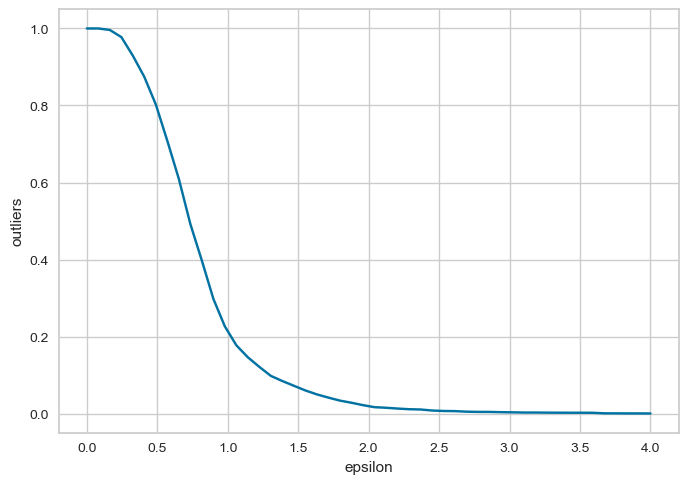

In [93]:
# Outlier proportion vs. eps value lineplot
sns.lineplot(data=models_df, x='epsilon', y='outliers');

In [94]:
# Based on the outlier plot, a reasonable epsilon value would be 3
model = DBSCAN(eps=3, min_samples=min_samples)
model.fit(X_pca)

DBSCAN(eps=3, min_samples=20)

In [95]:
# Add cluster to dataframe
original_df['cluster'] = model.labels_

#### Visualize clusters

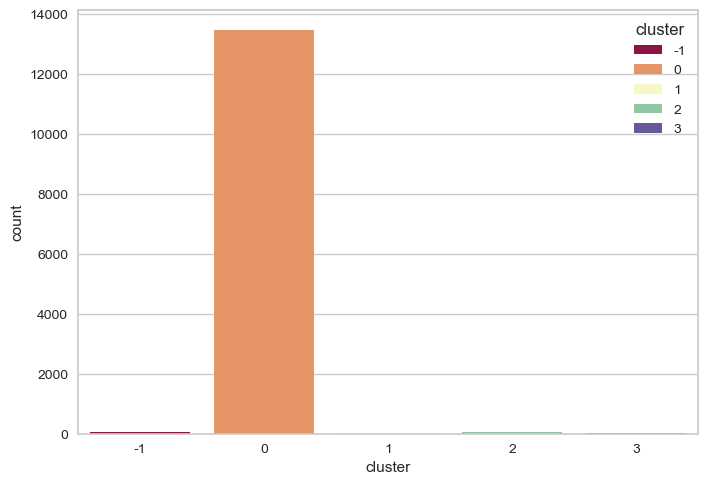

In [96]:
# Get distribution of clusters
sns.countplot(data=original_df, x='cluster', hue='cluster', palette='Spectral');

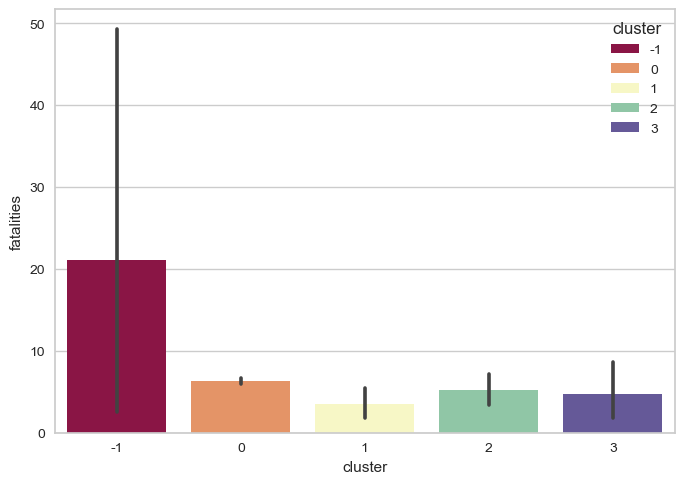

In [97]:
# Plot average number of fatalities by cluster
sns.barplot(data=original_df, x='cluster', y='fatalities', hue='cluster', palette='Spectral');

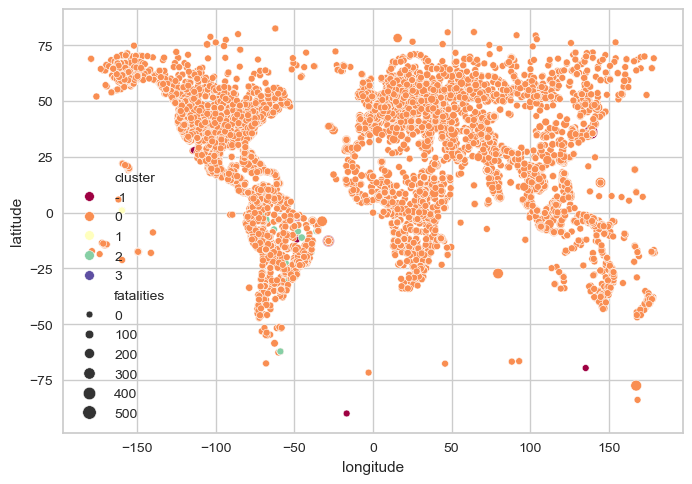

In [98]:
# Plot coordinates colored by clusters and sized by fatalities
sns.scatterplot(data=original_df, x='longitude', y='latitude', hue='cluster', size='fatalities', palette='Spectral');

#### Analyse each cluster

In [99]:
outliers = original_df[original_df['cluster'] == -1]
outliers.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
5504,-1,1986-07-22,Accident,Douglas DC-3,Borinquen Air,1943.0,Multi Piston Engines,Wright R-1820-202A,Takeoff (climb),Cargo,"Lake, Sea, Ocean, River","San Juan-Luis Muñoz Marín (Isla Verde), All Puerto Rico",Puerto Rico,Central America,18.439657,-65.998358,Destroyed,True,2,1,0.0,Technical failure
1696,-1,1975-01-01,Accident,Douglas C-47 Skytrain (DC-3),Air O'Hare,1943.0,Multi Piston Engines,Pratt & Whitney R-1830-92,Landing (descent or approach),Private,"Lake, Sea, Ocean, River","Fort Lauderdale-Hollywood, Florida",United States of America,North America,26.072017,-80.150997,Destroyed,True,3,0,0.0,Technical failure
1636,-1,1974-11-12,Accident,Douglas C-47 Skytrain (DC-3),Brazilian Air Force - Força Aérea Brasileira (1941-),1943.0,Multi Piston Engines,Pratt & Whitney R-1830-92,Flight,Military,"Plain, Valley","Tomé-Açu, Pará",Brazil,South America,-2.416631,-48.152291,Destroyed,False,7,7,0.0,Technical failure
5011,-1,1984-10-27,Unknown,Ilyushin II-76,Soviet Air Force - Voyenno-vozdushnye sily CCCP,1978.0,Multi Jet Engines,Unknown,Landing (descent or approach),Military,"Plain, Valley","Kabul, Kabul",Afghanistan,Asia,34.526643,69.184908,Destroyed,False,11,11,0.0,"Terrorism act, hijacking, sabotage, any kind of hostile action"
370,-1,1971-02-15,Accident,Lockheed C-130 Hercules,United States Navy - USN,1960.0,Multi Turboprop Engines,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"McMurdo Sound, All Antarctica",Antarctica,Antarctica,-77.833779,166.825563,Destroyed,False,0,0,0.0,Human factor


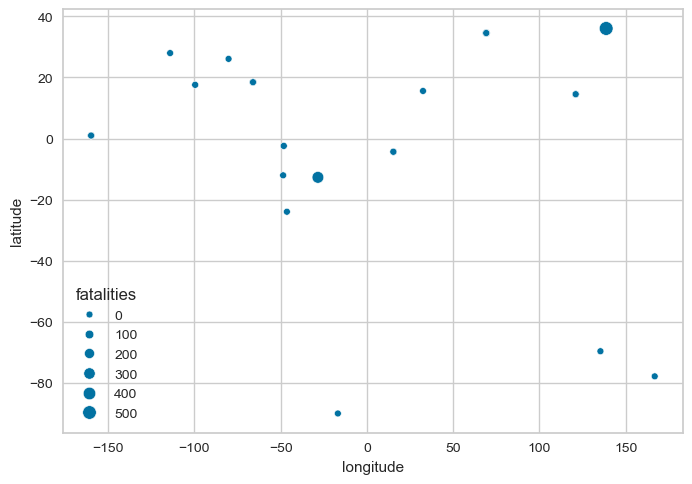

In [100]:
# Visualize outliers separately
sns.scatterplot(data=outliers, x='longitude', y='latitude', size='fatalities');

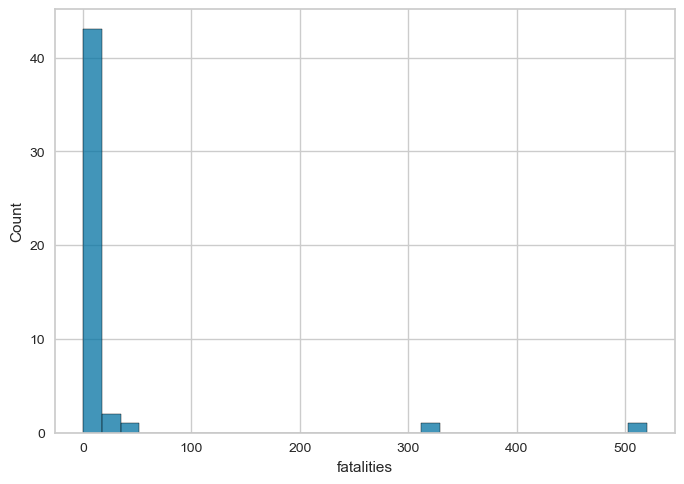

In [101]:
# Plot distribution of fatalities
sns.histplot(data=outliers, x='fatalities', bins=30);

In [102]:
outliers.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,48.0,48,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,-1.0,1987-04-28 12:00:00,1960.395833,11.447121,-12.299258,24.916667,21.145833,6.208333
min,-1.0,1970-02-15 00:00:00,1942.000000,-89.991843,-159.836729,0.000000,0.000000,0.000000
25%,-1.0,1978-08-03 12:00:00,1944.000000,11.128534,-65.998358,2.000000,0.000000,0.000000
50%,-1.0,1985-10-19 00:00:00,1961.000000,18.439657,-57.268614,5.000000,0.000000,0.000000
75%,-1.0,1996-12-27 06:00:00,1971.250000,26.546750,69.184908,8.750000,5.000000,0.000000
max,-1.0,2012-03-22 00:00:00,1995.000000,36.021749,166.825563,524.000000,520.000000,297.000000
std,0.0,NaN,14.508603,27.530046,85.522337,87.472265,87.643375,42.865429


In [103]:
outliers.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,48,48,48,48,48,48,48,48,48,48,48,48,48,48
unique,3,22,32,4,14,5,13,6,18,11,7,4,2,5
top,Accident,Douglas C-47 Skytrain (DC-3),Soviet Air Force - Voyenno-vozdushnye sily CCCP,Multi Piston Engines,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"San Juan-Luis Muñoz Marín (Isla Verde), All Puerto Rico",Puerto Rico,Central America,Destroyed,True,Human factor
freq,34,9,10,22,22,19,15,24,18,18,20,35,32,18


In [104]:
cluster0 = original_df[original_df['cluster'] == 0]
cluster0.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
1212,0,1973-07-23,Accident,Fairchild-Hiller FH-227,Ozark Air Lines,1966.0,Multi Turboprop Engines,Rolls-Royce Dart 532-7,Landing (descent or approach),Scheduled Revenue Flight,City,"Saint Louis-Lambert, Missouri",United States of America,North America,38.758131,-90.376011,Destroyed,True,44,38,0.0,Human factor
10135,0,2003-08-19,Accident,Cessna 208B Grand Caravan,Transworld Safaris,1997.0,1 Turboprop engine,Pratt & Whitney Canada PT6A-114,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),Airport (less than 10 km from airport),"Fangak (Old Fangak), Jonglei (جونقلي)",South Sudan,Africa,9.066893,30.880027,Destroyed,True,6,0,0.0,Human factor
3497,0,1980-01-15,Accident,IAI Arava 201,Umbufto Swaziland Defence Force,1979.0,Multi Turboprop Engines,Unknown,Flight,Delivery,Airport (less than 10 km from airport),"Zomba, Southern Region",Malawi,Africa,-15.386321,35.326827,Destroyed,False,2,2,0.0,Unknown
5448,0,1986-05-01,Accident,Douglas C-118 Liftmaster,Salvadorian Air Force - Fuerza Aérea Salvadoreña,1955.0,Multi Piston Engines,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"San Salvador-Ilopango, San Salvador",Salvador,Central America,13.701305,-89.078110,Destroyed,False,37,37,0.0,Technical failure
2464,0,1977-04-28,Accident,Boeing KC-135 Stratotanker,United States Air Force - USAF (since 1947),1959.0,Unknown,Pratt & Whitney J57-P,Landing (descent or approach),Training,Airport (less than 10 km from airport),"Beale AFB, California",United States of America,North America,39.122939,-121.380080,Destroyed,True,7,0,0.0,Other causes


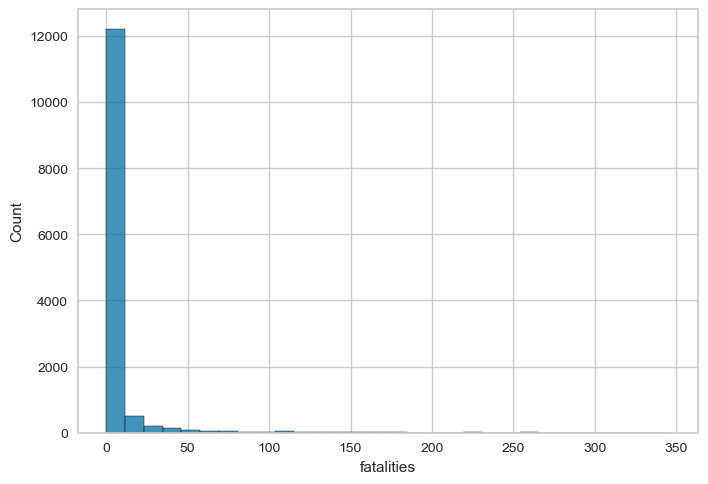

In [105]:
# Plot distribution of fatalities
sns.histplot(data=cluster0, x='fatalities', bins=30);

In [106]:
cluster0.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,13456.0,13456,13456.000000,13456.000000,13456.000000,13456.000000,13456.000000,13456.000000
mean,0.0,1992-09-06 02:16:20.261593344,1972.663273,27.351969,-19.767949,14.186014,6.329741,0.130202
min,0.0,1970-01-02 00:00:00,1900.000000,-83.899927,-179.491343,0.000000,0.000000,0.000000
25%,0.0,1979-11-01 18:00:00,1964.000000,11.838289,-86.585901,2.000000,0.000000,0.000000
50%,0.0,1990-09-24 00:00:00,1973.000000,33.885085,-53.456054,4.000000,1.000000,0.000000
75%,0.0,2004-02-17 06:00:00,1981.000000,45.144950,38.343833,9.000000,4.000000,0.000000
max,0.0,2025-03-17 00:00:00,2023.000000,82.525369,179.314337,468.000000,346.000000,180.000000
std,0.0,NaN,14.831834,25.242716,84.168132,33.992586,20.984920,2.428707


In [107]:
cluster0.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,13456,13456,13456,13456,13456,13456,13456,13456,13456,13456,13456,13456,13456,13456
unique,5,501,7082,7,782,6,32,7,8076,207,9,7,2,6
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Atlantic Ocean, All World",United States of America,North America,Destroyed,False,Human factor
freq,7009,757,858,6643,8694,5942,2977,7439,32,4103,4732,6226,6913,6399


In [108]:
cluster1 = original_df[original_df['cluster'] == 1]
cluster1.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
10216,1,2003-12-26,Unknown,PAC 750XL - Pacific Aerospace Corporation,Utility Aircraft Corporation,2003.0,Unknown,Unknown,Flight,Delivery,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Unknown,False,1,1,0.0,Technical failure
3147,1,1979-01-30,Accident,Boeing 707,VARIG - Viação Aérea Rio Grandense,1961.0,Multi Jet Engines,Pratt & Whitney JT3D-3B,Flight,Cargo,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Aircraft missing,False,6,6,0.0,Technical failure
7010,1,1991-06-18,Accident,Grumman G-64 Albatross,Pacific Flying Fish,1953.0,Multi Piston Engines,Wright R-1820-76D/C,Flight,Ferry,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Destroyed,True,3,0,0.0,Technical failure
2060,1,1976-02-11,Unknown,Beechcraft H18,Flight Service,1966.0,Unknown,Unknown,Flight,Ferry,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Unknown,False,1,1,0.0,Technical failure
4475,1,1982-12-09,Unknown,Piper PA-31-350 Navajo Chieftain,Brent's International,1973.0,Unknown,Unknown,Flight,Ferry,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,0.977229,-159.836729,Unknown,False,2,2,0.0,Technical failure


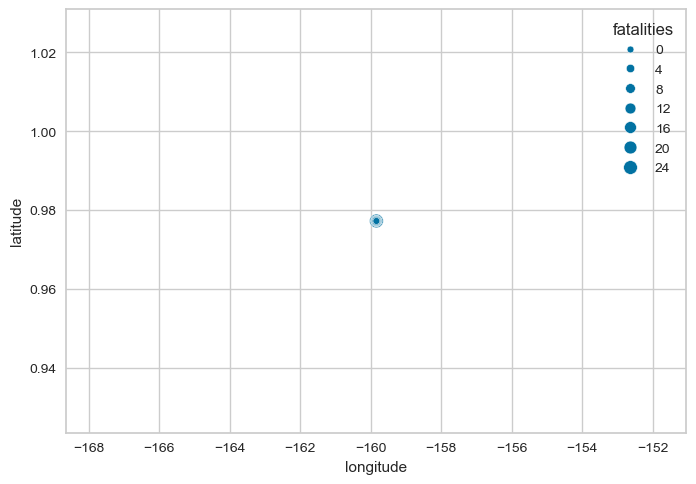

In [109]:
# Visualize cluster separately
sns.scatterplot(data=cluster1, x='longitude', y='latitude', size='fatalities');

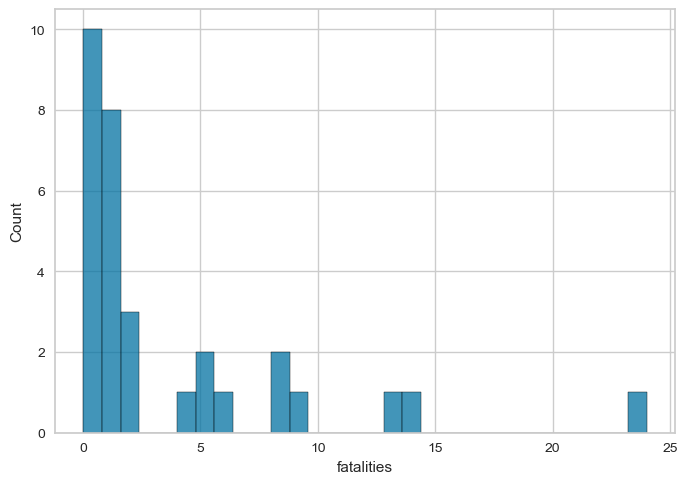

In [110]:
# Plot distribution of fatalities
sns.histplot(data=cluster1, x='fatalities', bins=30);

In [111]:
cluster1.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,31.0,31,31.000000,3.100000e+01,31.000000,31.000000,31.000000,31.0
mean,1.0,1988-02-11 15:29:01.935483840,1971.322581,9.772293e-01,-159.836729,4.677419,3.548387,0.0
min,1.0,1970-12-05 00:00:00,1943.000000,9.772293e-01,-159.836729,1.000000,0.000000,0.0
25%,1.0,1975-06-22 12:00:00,1957.500000,9.772293e-01,-159.836729,1.000000,0.000000,0.0
50%,1.0,1988-12-09 00:00:00,1969.000000,9.772293e-01,-159.836729,2.000000,1.000000,0.0
75%,1.0,1995-01-23 00:00:00,1976.500000,9.772293e-01,-159.836729,7.000000,5.000000,0.0
max,1.0,2020-11-06 00:00:00,2020.000000,9.772293e-01,-159.836729,24.000000,24.000000,0.0
std,0.0,NaN,19.054986,3.385725e-16,0.000000,5.461301,5.421185,0.0


In [112]:
cluster1.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,31,31,31,31,31,31,31,31,31,31,31,31,31,31
unique,2,26,27,5,10,1,10,1,1,1,1,3,2,3
top,Accident,Lockheed P-3 Orion,United States Navy - USN,Unknown,Unknown,Flight,Ferry,"Lake, Sea, Ocean, River","Pacific Ocean, All World",World,World,Unknown,False,Technical failure
freq,17,4,4,15,20,31,9,31,31,31,31,14,20,17


In [113]:
cluster2 = original_df[original_df['cluster'] == 2]
cluster2.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
6083,2,1988-06-04,Unknown,Grumman S-2 Tracker,Brazilian Air Force - Força Aérea Brasileira (1941-),1958.0,Unknown,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"Salvador-Deputado Luis Eduardo Magalhães (ex Dois de Julho), Bahia",Brazil,South America,-12.836991,-38.465024,Unknown,True,6,0,0.0,Unknown
5955,2,1987-12-14,Accident,Lockheed C-130 Hercules,Brazilian Air Force - Força Aérea Brasileira (1941-),1984.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,"Lake, Sea, Ocean, River","Vila dos Remédios, Pernambuco",Brazil,South America,-3.842186,-32.411139,Destroyed,False,29,29,0.0,Human factor
3283,2,1979-06-18,Accident,BAe 125,Brazilian Air Force - Força Aérea Brasileira (1941-),1968.0,Unknown,Unknown,Landing (descent or approach),Training,Airport (less than 10 km from airport),"Brasília, Distrito Federal",Brazil,South America,-15.793987,-47.882800,Destroyed,True,2,0,0.0,Unknown
5695,2,1987-03-26,Accident,Embraer C-95 Bandeirante,Brazilian Air Force - Força Aérea Brasileira (1941-),1983.0,Multi Turboprop Engines,P&W Canada PT6A,Takeoff (climb),Military,Mountains,"Campo dos Afonsos AFB, Rio de Janeiro",Brazil,South America,-22.874113,-43.374587,Destroyed,False,3,3,0.0,Human factor
5199,2,1985-06-27,Accident,Embraer C-95 Bandeirante,Brazilian Air Force - Força Aérea Brasileira (1941-),1977.0,Multi Turboprop Engines,P&W Canada PT6A,Flight,Training,"Lake, Sea, Ocean, River","Fortaleza, Ceará",Brazil,South America,-3.730451,-38.521799,Destroyed,False,4,4,0.0,Human factor


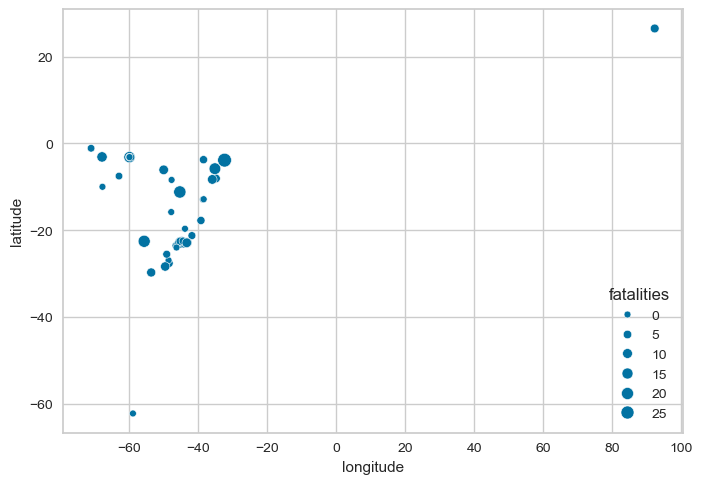

In [114]:
# Visualize cluster separately
sns.scatterplot(data=cluster2, x='longitude', y='latitude', size='fatalities');

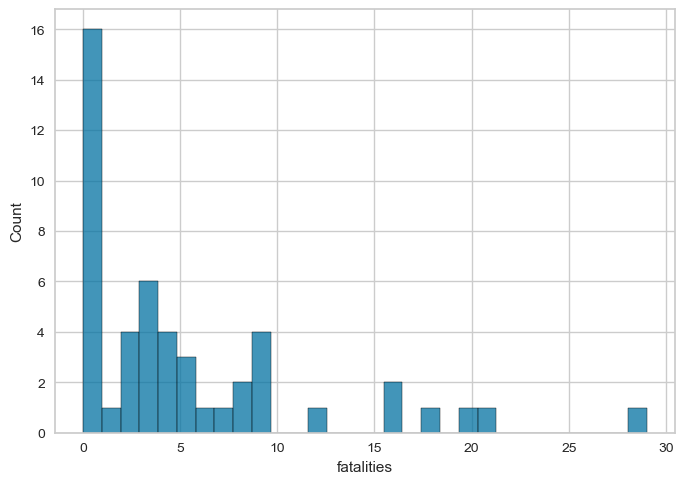

In [115]:
# Plot distribution of fatalities
sns.histplot(data=cluster2, x='fatalities', bins=30);

In [116]:
cluster2.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,49.0,49,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,2.0,1988-07-25 07:20:48.979591808,1971.979592,-14.713072,-41.960761,9.040816,5.204082,0.020408
min,2.0,1971-04-28 00:00:00,1943.000000,-62.191001,-71.120234,0.000000,0.000000,0.000000
25%,2.0,1978-10-04 00:00:00,1968.000000,-22.879519,-50.067941,3.000000,0.000000,0.000000
50%,2.0,1987-09-08 00:00:00,1975.000000,-17.734979,-45.190893,6.000000,3.000000,0.000000
75%,2.0,1996-08-30 00:00:00,1980.000000,-5.805398,-41.884308,10.000000,8.000000,0.000000
max,2.0,2015-07-27 00:00:00,2009.000000,26.492533,92.330879,85.000000,29.000000,1.000000
std,0.0,NaN,13.921641,13.975328,29.492996,12.908265,6.585905,0.142857


In [117]:
cluster2.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,49,49,49,49,49,49,49,49,49,49,49,49,49,49
unique,2,15,1,4,5,3,9,4,39,2,2,3,2,4
top,Accident,Embraer C-95 Bandeirante,Brazilian Air Force - Força Aérea Brasileira (1941-),Multi Turboprop Engines,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Ponta Pelada AFB, Manaus, Amazonas",Brazil,South America,Destroyed,False,Unknown
freq,43,20,49,32,26,20,28,26,4,48,48,41,27,26


In [118]:
cluster3 = original_df[original_df['cluster'] == 3]
cluster3.sample(5)

,cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
29,3,1970-01-31,Accident,Douglas C-47 Skytrain (DC-3),Colombian Air Force - Fuerza Aérea Colombiana,1951.0,Multi Piston Engines,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Destroyed,True,15,0,0.0,Technical failure
1167,3,1973-06-07,Accident,Vickers Viscount,Aerolineas TAO (Taxi Aéreo Opita),1957.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Destroyed,False,0,0,0.0,Unknown
579,3,1971-11-05,Unknown,De Havilland DHC-2 Beaver,Colombian Air Force - Fuerza Aérea Colombiana,1952.0,Unknown,Unknown,Takeoff (climb),Military,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Unknown,False,2,2,0.0,Technical failure
4986,3,1984-09-29,Unknown,Cessna 404 Titan,Private Colombian,1965.0,Unknown,Unknown,Takeoff (climb),Illegal (smuggling),Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Unknown,True,5,0,0.0,Unknown
10754,3,2006-08-17,Accident,Boeing 727-200,Aerosucre Colombia,1970.0,Multi Jet Engines,Pratt & Whitney JT8D-15,Taxiing,Cargo,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Destroyed,True,3,0,0.0,Technical failure


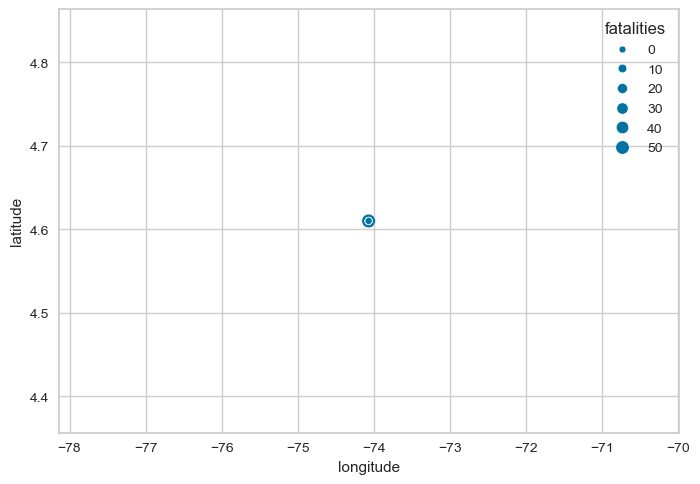

In [119]:
# Visualize cluster separately
sns.scatterplot(data=cluster3, x='longitude', y='latitude', size='fatalities');

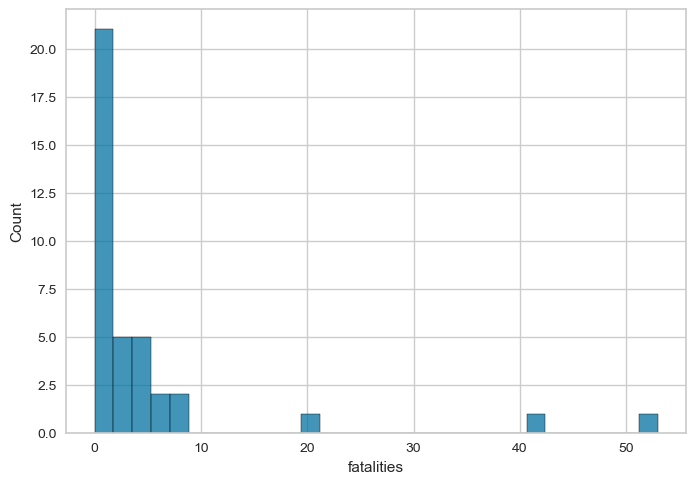

In [120]:
# Plot distribution of fatalities
sns.histplot(data=cluster3, x='fatalities', bins=30);

In [121]:
cluster3.describe()

,cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,38.0,38,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,3.0,1987-09-05 04:25:15.789473664,1963.500000,4.610017,-74.069303,11.842105,4.684211,0.473684
min,3.0,1970-01-31 00:00:00,1943.000000,4.610017,-74.069303,0.000000,0.000000,0.000000
25%,3.0,1975-07-10 00:00:00,1952.750000,4.610017,-74.069303,3.000000,0.000000,0.000000
50%,3.0,1985-12-16 00:00:00,1963.500000,4.610017,-74.069303,5.000000,0.000000,0.000000
75%,3.0,1995-05-30 00:00:00,1970.750000,4.610017,-74.069303,8.750000,4.750000,0.000000
max,3.0,2016-10-28 00:00:00,1995.000000,4.610017,-74.069303,85.000000,53.000000,6.000000
std,0.0,NaN,13.775713,0.000000,0.000000,18.668555,11.003943,1.370280


In [122]:
cluster3.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,38,38,38,38,38,38,38,38,38,38,38,38,38,38
unique,3,29,29,4,10,5,11,4,1,1,1,3,2,4
top,Accident,Sud-Aviation SE-210 Caravelle,Private Colombian,Unknown,Unknown,Takeoff (climb),Cargo,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,Destroyed,True,Technical failure
freq,25,3,3,13,28,25,14,26,38,38,38,25,20,19


#### Observations

**Outliers:** It includes two of the deadliest accidents.<br>

0. Most of the accidents
1. They all crashed in the Pacific Ocean, low number of occupants.
2. All the flights are with the Brazilian Air Force.
3. All the flights crashed in the same location in Colombia.

### Compare the different clusterings

For the K-Means clustering, the date doesn't seem to be an important factor, whereas the location and the fatalities are important factors. The aircraft type and engine seems to be an important factor as well. One factor that seems to have influenced the DBSCAN the most is the location. Both clustering methods grouped Brazilian flights, which is very interesting.

## End